In [213]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import warnings
import math
from typing import Callable, Optional

In [3]:
type DataMatrix = np.ndarray
type GramMatrix = np.ndarray
type GramMatrices = list[GramMatrix]
type Axis = int
type FactorMatrix = np.ndarray
type DiagonalOffset = int
type NumToKeep = int
type SparsityPercent = float
type StepSize = float

@dataclass
class KSParameterization:
    """
    (kronsum_i^K L_i) + c_i * I
    where trace(L_i) = 0
    """
    Ls: list[FactorMatrix]
    c: DiagonalOffset = field(default=0.0)
    K: int = field(init=False)
    ds: list[int] = field(init=False)

    def __post_init__(self):
        self.K = len(self.Ls)
        if self.K <= 1:
            raise ValueError("K must be greater than 1")
        
        for L in self.Ls:
            if len(L.shape) != 2:
                raise ValueError("L must be a square 2D matrix")
            if L.shape[0] != L.shape[1]:
                raise ValueError("L must be a square matrix")
            
        self.ds = [L.shape[0] for L in self.Ls]

        self.identify()

    def identify(self):
        """
        Adjust the parameterization to an identifiable form.
        """
        for L in self.Ls:
            trL = np.trace(L)
            L -= (trL / L.shape[0]) * np.eye(L.shape[0])
            self.c += trL / L.shape[0]

    def __add__(self, other: "KSParameterization") -> "KSParameterization":
        """
        Add two parameterizations.
        """
        if self.K != other.K:
            raise ValueError("K must be the same for both parameterizations")
        
        new_Ls = [self.Ls[i] + other.Ls[i] for i in range(self.K)]
        new_c = self.c + other.c
        return KSParameterization(new_Ls, new_c)

    def __mul__(self, scalar: float) -> "KSParameterization":
        """
        Scale the parameterization by a scalar.
        """
        new_Ls = [scalar * L for L in self.Ls]
        new_c = scalar * self.c
        return KSParameterization(new_Ls, new_c)
    
    def __rmul__(self, scalar: float) -> "KSParameterization":
        """
        Reverse multiplication with a scalar.
        """
        return self * scalar
    
    def __sub__(self, other: "KSParameterization") -> "KSParameterization":
        return self + (-1 * other)
    
    def actualize(self) -> np.ndarray:
        """
        Compute Kronecker sum of factor matrices.
        """
        D = np.prod(self.ds)
        out = np.zeros((D, D))
        for i in range(self.K):
            D_less = int(np.prod(self.ds[:i]))
            D_more = int(np.prod(self.ds[i + 1:]))
            L = self.Ls[i]
            out += np.kron(np.eye(D_less), np.kron(L, np.eye(D_more)))
        out += self.c * np.eye(D)
        return out

def generate_KSParameterization(
    ds: list[int],
    sp: SparsityPercent
) -> DataMatrix:
    # Generate random triangular matrices with strictly positive diagonals
    Ls = [np.random.normal(size=(d, d)) for d in ds]
    for i, L in enumerate(Ls):
        # Make the matrix triangular
        L = np.tril(L)

        # Make the diagonal positive
        L_diag = np.diag(np.diag(L))
        np.fill_diagonal(L, 0)
        L += np.abs(L_diag)

        # Make the diagonal strictly positive
        L += np.eye(L.shape[0]) * 1e-6

        # Remove ~sp% of the off-diagonal elements randomly
        # Do this by creating a Bernoulli mask
        mask = np.random.rand(*L.shape) > sp

        # Ensure diagonal is not masked
        np.fill_diagonal(mask, 0)
        L[mask] = 0
        Ls[i] = L

    # Create the KSParameterization
    L = KSParameterization(Ls)
    return L
def generate_data(L: KSParameterization) -> DataMatrix:
    """
    Generates data from the Cartesian LGAM model.

    Amusingly, even though this is a "generative model", a naive
    approach is **very** computationally expensive.

    We need to solve L^-1 * e where e is i.i.d. standard normal
    and L is a Kronecker sum of matrices.

    This could be done in O(d^[3K]) time... i.e. sextic for K=2!!!

    A less-naive way is to use specialized triangular-solvers.  These
    still require the computation of L and the solve, which is O(d^(2K)) time,
    i.e. quartic for K=2.  That's what is implemented here.

    A more advanced method can be achieved with the Bartels–Stewart algorithm
    in the K=2 case, which is implemented in scipy as `scipy.linalg.solve_sylvester`.
    But scipy does not implement this in the K>2 case, so I have not either.
    In the K=2 case, though, runtime is cubic - which is about as good as we could
    have ever hoped for!
    """

    # Half-naive approach: actualize L and solve triangular system:
    L_actual = L.actualize()

    # Generate i.i.d. standard normal data
    e = np.random.normal(size=L_actual.shape[0])

    # Solve the triangular system
    x = linalg.solve_triangular(L_actual, e, lower=True)

    # Reshape the data to the original dimensions
    data_shape = tuple(L.ds)
    data = x.reshape(data_shape)
    return data

L_star = generate_KSParameterization((10, 10), 1)
X = generate_data(L_star)
X /= np.linalg.norm(X, ord=2)
X

array([[-4.92482961e-08,  3.57700733e-08, -6.38237323e-08,
         1.28694087e-08, -5.98234269e-08, -8.64873783e-09,
         1.12827958e-07, -1.01577866e-07, -1.15236857e-07,
        -7.22809246e-08],
       [-1.49942229e-06,  2.73282612e-06, -3.77776438e-06,
        -6.33033769e-06, -7.29908928e-06,  1.37936079e-04,
        -2.80850243e-04,  4.08583718e-04,  1.17947141e-03,
        -1.46467493e-03],
       [-1.00736416e-06,  1.81528770e-06, -2.58437541e-06,
        -4.44402208e-06, -5.07216874e-06,  9.79475248e-05,
        -1.99626407e-04,  2.90355688e-04,  8.37650877e-04,
        -1.03982350e-03],
       [ 6.84397344e-06, -1.47198873e-05,  1.98220753e-05,
         3.63536041e-05,  4.08062980e-05, -1.03544124e-03,
         2.16086029e-03, -3.21257789e-03, -9.14363783e-03,
         1.14253326e-02],
       [-5.92670561e-06,  1.38636927e-05, -1.81797830e-05,
        -3.48824718e-05, -3.87809358e-05,  1.21459413e-03,
        -2.57231565e-03,  3.88515182e-03,  1.09617931e-02,
        -1.

In [ ]:
type FactorMatrix = np.ndarray
type InputData = np.ndarray
type ObjectiveOracle = Callable[[list[FactorMatrix], bool], float | tuple[float, float]]
type ProjectionOracle = Callable[[list[FactorMatrix]], float]
type ProximalOracle = Callable[[list[FactorMatrix]], float]
type GradientOracle = Callable[[list[FactorMatrix]], Direction]
type HessianUpdateOracle = Callable[[list[FactorMatrix]], Direction]
type Direction = list[FactorMatrix]
type Projection = Callable[[list[FactorMatrix]], list[FactorMatrix]]
type StepSize = float
type Momentum = float
type Diagnostics = tuple[np.ndarray, np.ndarray, np.ndarray, list[np.ndarray]]

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_79245/3554713877.py:77: RuntimeWarning: invalid value encountered in log
  log_term = -2 * np.log(np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1)).sum()
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_79245/3554713877.py:142: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(np.array(objs) - min(objs)))
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_79245/3554713877.py:146: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(np.array(eps)))


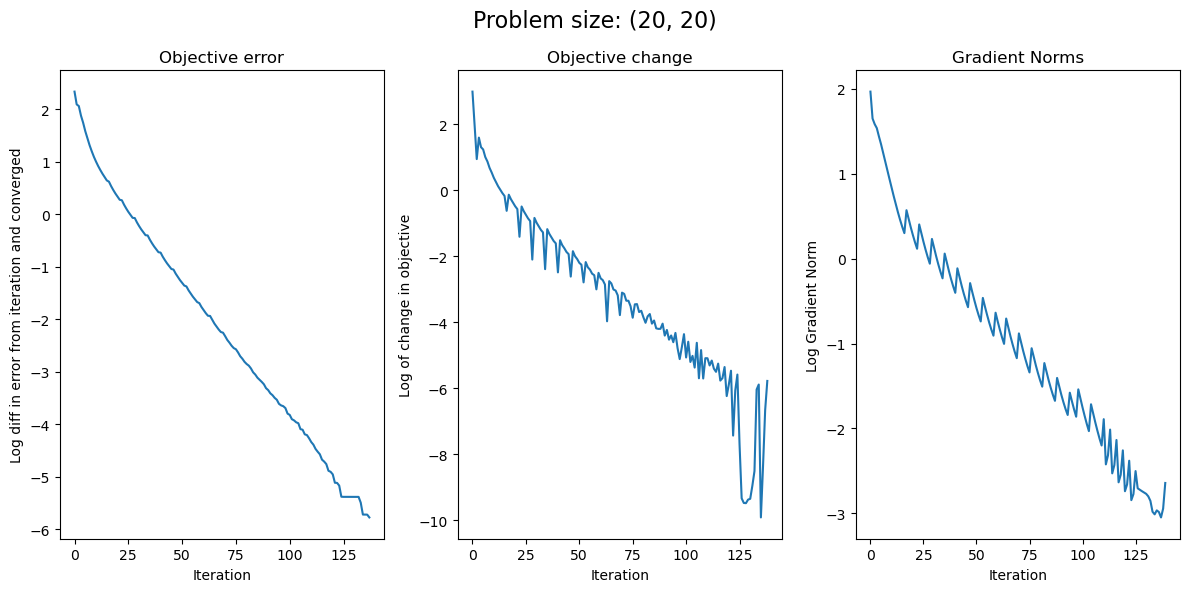

In [ ]:
def backtracking_line_search(
    f: ObjectiveOracle,
    P: ProjectionOracle,
    del_f: Direction,
    Ls: list[FactorMatrix],
    init_alpha: StepSize,
    tau: float,
    beta: float
) -> list[FactorMatrix]:
    """
    Backtracking line search
    """
    alpha = init_alpha
    
    cur_f = f(Ls)

    while True:
        new_Ls = P([L - alpha * d for L, d in zip(Ls, del_f)])
        new_f = f(new_Ls)
        if new_f <= cur_f - alpha * beta * np.sum([np.linalg.norm(d)**2 for d in del_f]):
            break
        alpha *= tau
    return new_Ls

def gradient_descent(
    f: ObjectiveOracle,
    del_f: GradientOracle,
    P: ProjectionOracle,
    Ls: list[FactorMatrix],
    init_alpha: StepSize,
    tau: float,
    beta: float,
    max_iter: int = 1000,
    tol: float = 1e-5,
) -> tuple[list[FactorMatrix], Diagnostics]:
    """
    Gradient descent algorithm
    """

    cur_f = f(Ls)

    objs = []
    eps = []
    grads = []
    
    for _ in range(max_iter):
        grad = del_f(Ls)
        Ls = backtracking_line_search(f, P, grad, Ls, init_alpha, tau, beta)

        new_f = f(Ls)
        delta = np.abs(new_f - cur_f)
        objs.append(new_f)
        eps.append(delta)
        grads.append(sum([np.linalg.norm(g) for g in grad]))
        
        if delta < tol:
            break
        cur_f = new_f

    return Ls, (objs, eps, grads)


def get_optimizer_oracles(
    X: InputData,
    frobreg: float = 0,
    glassoreg: float = 0
) -> tuple[ObjectiveOracle, GradientOracle]:
    """
    Creates oracles from our input data
    """
    objective: ObjectiveOracle
    def objective(Ls: list[FactorMatrix], smooth=False) -> float:
        if (len(Ls) != 2):
            raise NotImplementedError("Tensor-variate not yet supported")
        L1, L2 = Ls
        trace_term = ((L1 @ X + X @ L2.T)**2).sum()
        log_term = -2 * np.log(np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1)).sum()
        frob_term = frobreg * ((L1**2).sum() + (L2**2).sum())
        glasso_term = glassoreg * np.abs(np.tril(L1, k=-1)).sum()
        return trace_term + log_term + frob_term + glasso_term
    
    gradient: GradientOracle
    def gradient(Ls: list[FactorMatrix]) -> Direction:
        if (len(Ls) != 2):
            raise NotImplementedError("Tensor-variate not yet supported")
        L1, L2 = Ls

        trace_term_L1 = np.tril(2 * (L1 @ X @ X.T + X @ L2.T @ X.T), k=0)
        log_term_L1 = - (2  / (np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1))).sum(axis=1)
        grad_L1 = trace_term_L1 + np.diag(log_term_L1) + 2*frobreg*L1

        trace_term_L2 = np.tril(2 * (L2 @ X.T @ X + X.T @ L1 @ X), k=0)
        log_term_L2 = - (2  / (np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1))).sum(axis=0)
        grad_L2 = trace_term_L2 + np.diag(log_term_L2) + 2*frobreg*L2

        return [grad_L1, grad_L2]
    return objective, gradient

project_to_lower_with_positive_diag: Projection
def project_to_lower_with_positive_diag(Ms: list[FactorMatrix], tol=1e-6) -> list[FactorMatrix]:
    """
    Project M to strictly lower-triangular + positive diagonal
    """

    Ls = []
    for M in Ms:
        L = np.tril(M)
        np.fill_diagonal(L, np.maximum(np.diag(L), tol))  # Ensure positive diag
        Ls.append(L)
    return Ls

np.random.seed(2)
n = (20, 20)
L_star = generate_KSParameterization(n, 1)
X = generate_data(L_star)
X /= np.linalg.norm(X, ord=2)

L1_init = np.tril(np.random.randn(n[0], n[0]))
np.fill_diagonal(L1_init, np.abs(np.diag(L1_init)) + 1.0)
L2_init = np.tril(np.random.randn(n[1], n[1]))
np.fill_diagonal(L2_init, np.abs(np.diag(L2_init)) + 1.0)
L_init = [L1_init, L2_init]

frobreg = 1/np.prod(n)**(1/len(n))
glassoreg = 0
objective, gradient = get_optimizer_oracles(X, frobreg=frobreg, glassoreg=glassoreg)

Ls, (objs, eps, grads) = gradient_descent(
    f=objective,
    del_f=gradient,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-20
)

# Plot convergence
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 6))
ax1.plot(np.log10(np.array(objs) - min(objs)))
ax1.set_title("Objective error")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Log diff in error from iteration and converged")
ax2.plot(np.log10(np.array(eps)))
ax2.set_title("Objective change")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Log of change in objective")
ax3.plot(np.log10(np.array(grads)))
ax3.set_title("Gradient Norms")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Log Gradient Norm")
fig.suptitle(f"Problem size: {n}", fontsize=16)
fig.tight_layout()

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_79245/3724234615.py:170: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(np.array(objs) - min(objs)))


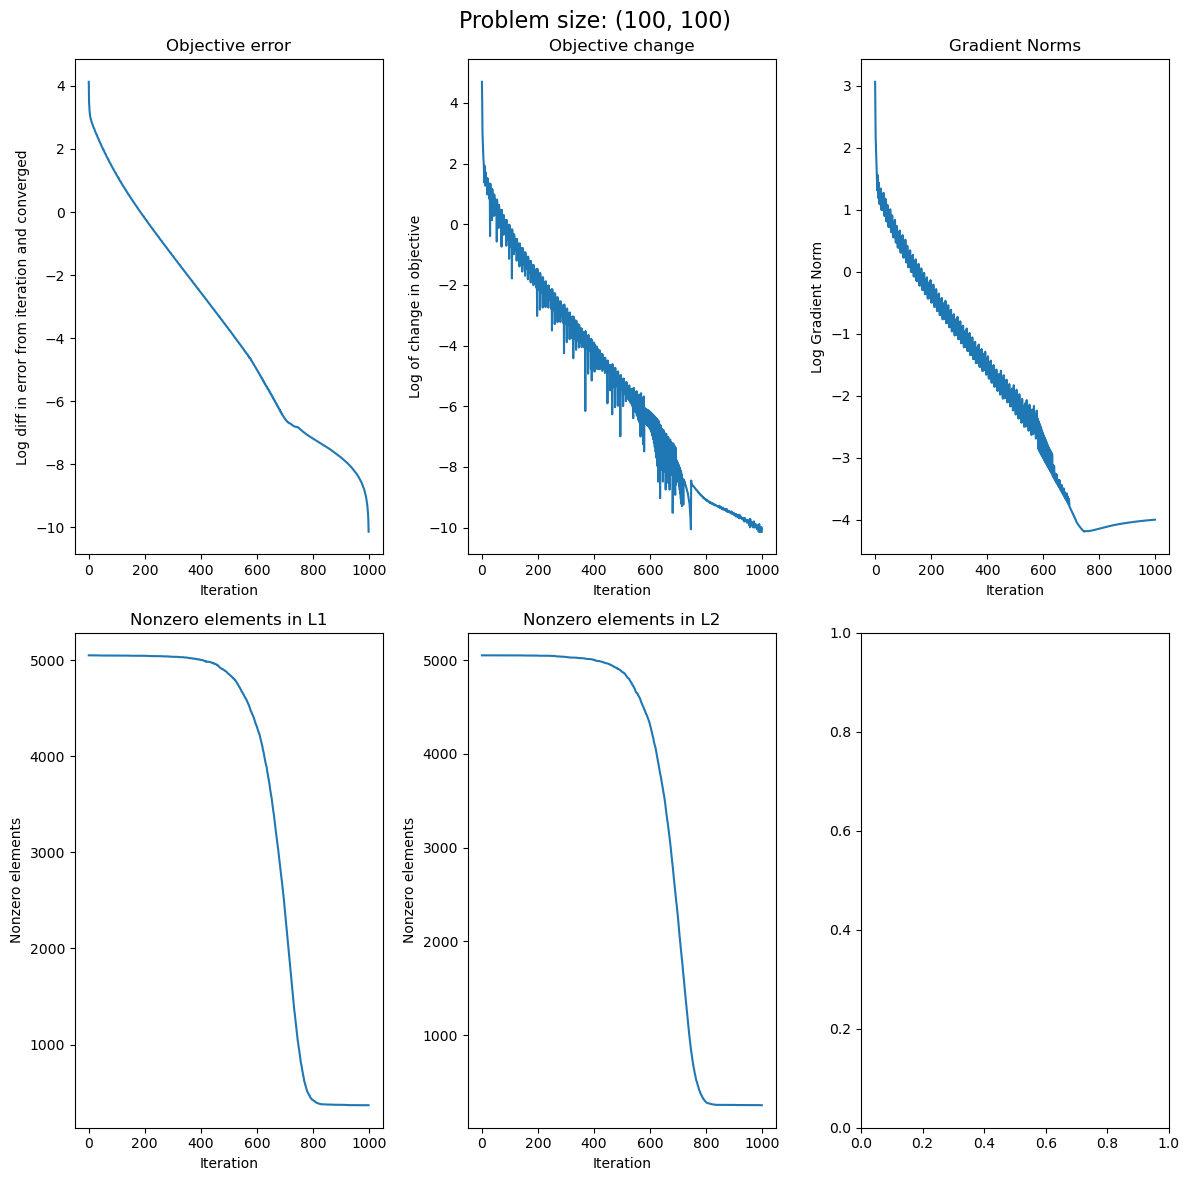

In [34]:
def proximal_backtracking_line_search(
    f: ObjectiveOracle,
    prox: ProximalOracle,
    P: ProjectionOracle,
    del_f: Direction,
    Ls: list[FactorMatrix],
    init_alpha: StepSize,
    tau: float,
    beta: float
) -> list[FactorMatrix]:
    """
    Backtracking line search
    """
    alpha = init_alpha
    
    cur_f = f(Ls)
    while True:
        new_Ls = prox(P([L - alpha * d for L, d in zip(Ls, del_f)]))
        new_f = f(new_Ls)
        prox_direc = [(L - Lnew) for L, Lnew in zip(Ls, new_Ls)]
        grad_norm = sum([np.linalg.norm(d)**2 for d in prox_direc])
        if new_f <= cur_f - beta * grad_norm / alpha:
            break
        alpha *= tau
        if alpha < 1e-30:
            warnings.warn("Alpha too small, stopping line search")
            return Ls

    return new_Ls

def proximal_gradient_descent(
    f: ObjectiveOracle,
    del_f: GradientOracle,
    prox: ProximalOracle,
    P: ProjectionOracle,
    Ls: list[FactorMatrix],
    init_alpha: StepSize,
    tau: float,
    beta: float,
    max_iter: int = 1000,
    tol: float = 1e-5,
) -> tuple[list[FactorMatrix], Diagnostics]:
    """
    Gradient descent algorithm
    """

    cur_f = f(Ls)

    objs = []
    eps = []
    grads = []
    nonzeros = [[], []]
    
    for _ in range(max_iter):
        grad = del_f(Ls)
        Ls = proximal_backtracking_line_search(f, prox, P, grad, Ls, init_alpha, tau, beta)

        new_f = f(Ls)
        delta = new_f - cur_f
        objs.append(new_f)
        eps.append(delta)
        grads.append(sum([np.linalg.norm(g) for g in grad]))
        nonzeros[0].append(np.count_nonzero(Ls[0]))
        nonzeros[1].append(np.count_nonzero(Ls[1]))
        
        if np.abs(delta) < tol:
            break
        cur_f = new_f

    return Ls, (objs, eps, grads, nonzeros)


def get_optimizer_oracles(
    X: InputData,
    frobreg: float = 0,
    glassoreg: float = 0
) -> tuple[ObjectiveOracle, GradientOracle, ProximalOracle]:
    """
    Creates oracles from our input data
    """
    objective: ObjectiveOracle
    def objective(Ls: list[FactorMatrix], decomp=False) -> float:
        if (len(Ls) != 2):
            raise NotImplementedError("Tensor-variate not yet supported")
        L1, L2 = Ls
        trace_term = ((L1 @ X + X @ L2.T)**2).sum()
        log_term = -2 * np.log(np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1)).sum()
        frob_term = frobreg * ((L1**2).sum() + (L2**2).sum())
        differentiable_term = trace_term + log_term + frob_term
        nondifferentiable_term = glassoreg * sum([np.abs(np.tril(L)).sum() for L in Ls])
        if decomp:
            return differentiable_term, nondifferentiable_term
        return differentiable_term + nondifferentiable_term
    
    gradient: GradientOracle
    def gradient(Ls: list[FactorMatrix]) -> Direction:
        if (len(Ls) != 2):
            raise NotImplementedError("Tensor-variate not yet supported")
        L1, L2 = Ls

        trace_term_L1 = np.tril(2 * (L1 @ X @ X.T + X @ L2.T @ X.T), k=0)
        log_term_L1 = - (2  / (np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1))).sum(axis=1)
        grad_L1 = trace_term_L1 + np.diag(log_term_L1) + 2*frobreg*L1

        trace_term_L2 = np.tril(2 * (L2 @ X.T @ X + X.T @ L1 @ X), k=0)
        log_term_L2 = - (2  / (np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1))).sum(axis=0)
        grad_L2 = trace_term_L2 + np.diag(log_term_L2) + 2*frobreg*L2

        return [grad_L1, grad_L2]
    
    proximal: ProximalOracle
    def proximal(Ls: list[FactorMatrix]) -> list[FactorMatrix]:
        """
        Soft thresholding on each of the Ls, not affecting their diagonals
        """
        new_Ls = []
        for L in Ls:
            L_diag = np.diag(L)
            new_L = np.sign(L) * np.maximum(np.abs(L) - glassoreg, 0)
            np.fill_diagonal(new_L, L_diag)
            new_Ls.append(new_L)
        return new_Ls
    
    return objective, gradient, proximal

project_to_lower_with_positive_diag: Projection
def project_to_lower_with_positive_diag(Ms: list[FactorMatrix], tol=1e-6) -> list[FactorMatrix]:
    """
    Project M to strictly lower-triangular + positive diagonal
    """

    Ls = []
    for M in Ms:
        L = np.tril(M)
        np.fill_diagonal(L, np.maximum(np.diag(L), tol))  # Ensure positive diag
        Ls.append(L)
    return Ls

np.random.seed(0)
n = (100, 100)
L_star = generate_KSParameterization(n, 1)
X = generate_data(L_star)
X /= np.linalg.norm(X, ord=2)

L1_init = np.tril(np.random.randn(n[0], n[0]))
np.fill_diagonal(L1_init, np.abs(np.diag(L1_init)) + 1.0)
L2_init = np.tril(np.random.randn(n[1], n[1]))
np.fill_diagonal(L2_init, np.abs(np.diag(L2_init)) + 1.0)
L_init = [L1_init, L2_init]

frobreg = 1/np.prod(n)**(1/len(n))
glassoreg = 1e-6
objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoreg=glassoreg)

Ls, (objs, eps, grads, nonzeros) = proximal_gradient_descent(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-20
)

# Plot convergence
fig, ((ax1, ax2, ax3), (ax4, ax5, _)) = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
ax1.plot(np.log10(np.array(objs) - min(objs)))
ax1.set_title("Objective error")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Log diff in error from iteration and converged")
ax2.plot(np.log10(-np.array(eps)))
ax2.set_title("Objective change")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Log of change in objective")
ax3.plot(np.log10(np.array(grads)))
ax3.set_title("Gradient Norms")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Log Gradient Norm")
ax4.plot(nonzeros[0])
ax4.set_title("Nonzero elements in L1")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Nonzero elements")
ax5.plot(nonzeros[1])
ax5.set_title("Nonzero elements in L2")
ax5.set_xlabel("Iteration")
ax5.set_ylabel("Nonzero elements")
fig.suptitle(f"Problem size: {n}", fontsize=16)
fig.tight_layout()

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2945758262.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2945758262.py:179: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(np.array(objs) - min(objs)))
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2945758262.py:183: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(-np.array(eps)))
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2945758262.py:183: RuntimeWarning: invalid value encountered in log10
  ax2.plot(np.log10(-np.array(eps)))


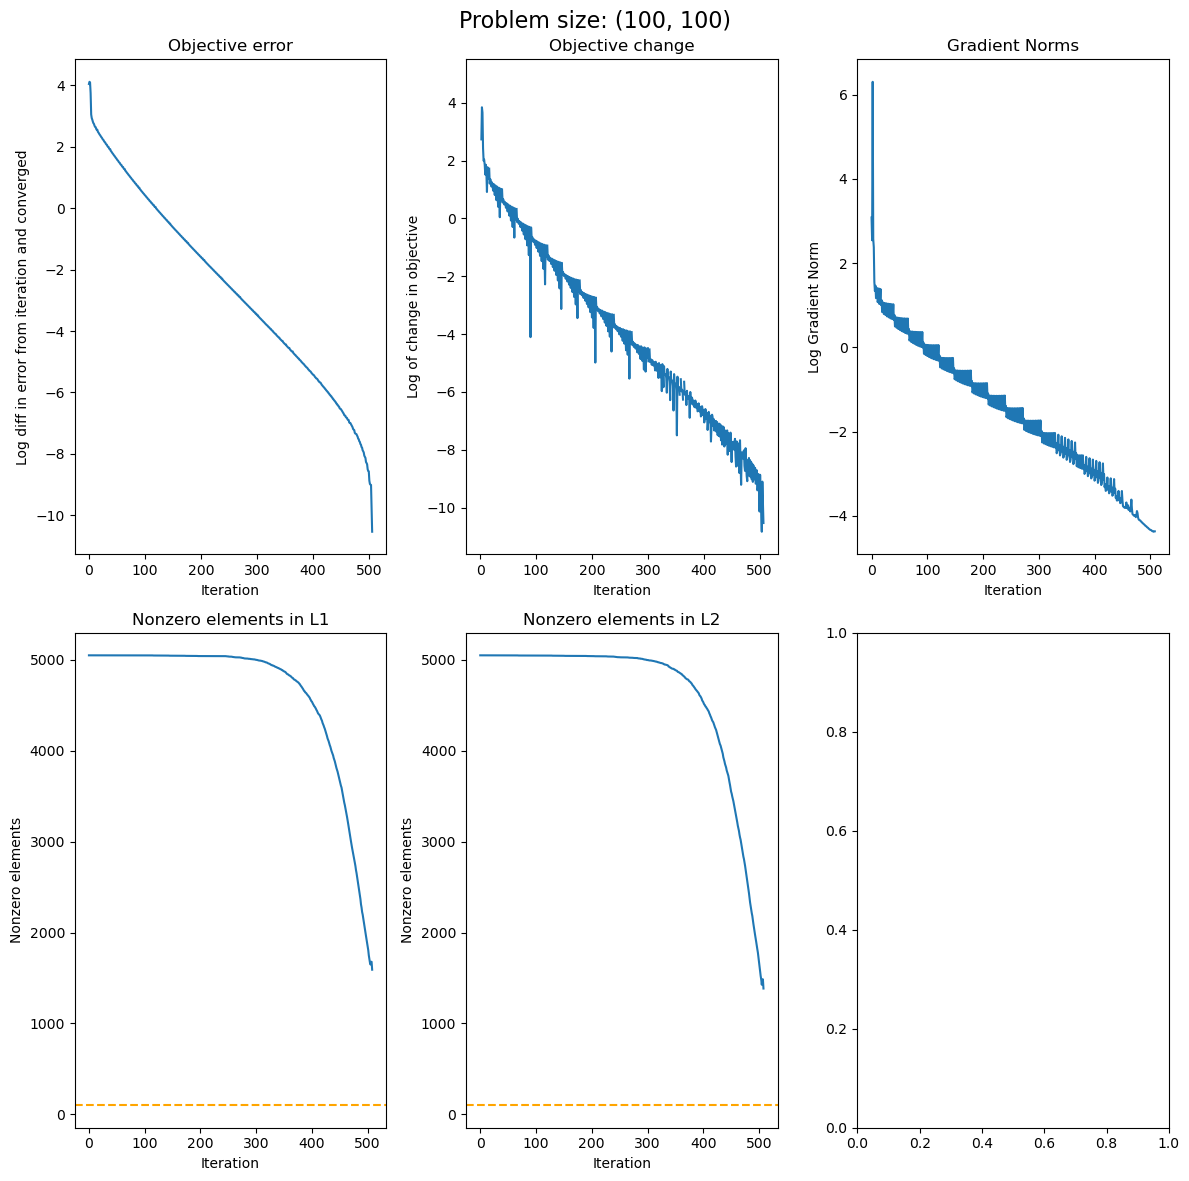

In [104]:
def proximal_backtracking_line_search(
    f: ObjectiveOracle,
    prox: ProximalOracle,
    P: ProjectionOracle,
    del_f: Direction,
    Ls: list[FactorMatrix],
    init_alpha: StepSize,
    tau: float,
    beta: float
) -> list[FactorMatrix]:
    """
    Backtracking line search
    """
    alpha = init_alpha
    
    cur_f = f(Ls)
    while True:
        new_Ls = prox(P([L - alpha * d for L, d in zip(Ls, del_f)]))
        new_f = f(new_Ls)
        prox_direc = [(L - Lnew) for L, Lnew in zip(Ls, new_Ls)]
        grad_norm = sum([np.linalg.norm(d)**2 for d in prox_direc])
        if new_f <= cur_f - beta * grad_norm / alpha:
            break
        alpha *= tau
        if alpha < 1e-30:
            warnings.warn("Alpha too small, stopping line search")
            return Ls

    return new_Ls

def proximal_accelerated_gradient(
    f: ObjectiveOracle,
    del_f: GradientOracle,
    prox: ProximalOracle,
    P: ProjectionOracle,
    Ls: list[FactorMatrix],
    mu: Momentum,
    init_alpha: StepSize,
    tau: float,
    beta: float,
    max_iter: int = 1000,
    tol: float = 1e-5,
) -> tuple[list[FactorMatrix], Diagnostics]:
    """
    Gradient descent algorithm
    """

    cur_f = f(Ls)

    objs = []
    eps = []
    grads = []
    nonzeros = [[], []]
    
    for i in range(max_iter):
        grad = del_f(Ls)
        if i > 0:
            accelerated_Ls = P([L + mu * (L - old_L) for L, old_L in zip(Ls, oldest_Ls)])
        else:
            accelerated_Ls = Ls
        oldest_Ls = Ls
        Ls = proximal_backtracking_line_search(f, prox, P, grad, accelerated_Ls, init_alpha, tau, beta)

        new_f = f(Ls)
        delta = new_f - cur_f
        objs.append(new_f)
        eps.append(delta)
        grads.append(sum([np.linalg.norm(g) for g in grad]))
        nonzeros[0].append(np.count_nonzero(Ls[0]))
        nonzeros[1].append(np.count_nonzero(Ls[1]))
        
        if np.abs(delta) < tol:
            break
        cur_f = new_f

    return Ls, (objs, eps, grads, nonzeros)


def get_optimizer_oracles(
    X: InputData,
    frobreg: float = 0,
    glassoreg: float = 0
) -> tuple[ObjectiveOracle, GradientOracle, ProximalOracle]:
    """
    Creates oracles from our input data
    """
    objective: ObjectiveOracle
    def objective(Ls: list[FactorMatrix], decomp=False) -> float:
        if (len(Ls) != 2):
            raise NotImplementedError("Tensor-variate not yet supported")
        L1, L2 = Ls
        trace_term = ((L1 @ X + X @ L2.T)**2).sum()
        log_term = -2 * np.log(np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1)).sum()
        frob_term = frobreg * ((L1**2).sum() + (L2**2).sum())
        differentiable_term = trace_term + log_term + frob_term
        if (np.isnan(differentiable_term)):
            raise ValueError("NaN in differentiable term")
        nondifferentiable_term = glassoreg * sum([np.abs(np.tril(L)).sum() for L in Ls])
        if decomp:
            return differentiable_term, nondifferentiable_term
        return differentiable_term + nondifferentiable_term
    
    gradient: GradientOracle
    def gradient(Ls: list[FactorMatrix]) -> Direction:
        if (len(Ls) != 2):
            raise NotImplementedError("Tensor-variate not yet supported")
        L1, L2 = Ls

        trace_term_L1 = np.tril(2 * (L1 @ X @ X.T + X @ L2.T @ X.T), k=0)
        log_term_L1 = - (2  / (np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1))).sum(axis=1)
        grad_L1 = trace_term_L1 + np.diag(log_term_L1) + 2*frobreg*L1

        trace_term_L2 = np.tril(2 * (L2 @ X.T @ X + X.T @ L1 @ X), k=0)
        log_term_L2 = - (2  / (np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1))).sum(axis=0)
        grad_L2 = trace_term_L2 + np.diag(log_term_L2) + 2*frobreg*L2

        return [grad_L1, grad_L2]
    
    proximal: ProximalOracle
    def proximal(Ls: list[FactorMatrix]) -> list[FactorMatrix]:
        """
        Soft thresholding on each of the Ls, not affecting their diagonals
        """
        new_Ls = []
        for L in Ls:
            L_diag = np.diag(L)
            new_L = np.sign(L) * np.maximum(np.abs(L) - glassoreg, 0)
            np.fill_diagonal(new_L, L_diag)
            new_Ls.append(new_L)
        return new_Ls
    
    return objective, gradient, proximal

project_to_lower_with_positive_diag: Projection
def project_to_lower_with_positive_diag(Ms: list[FactorMatrix], tol=1e-6) -> list[FactorMatrix]:
    """
    Project M to strictly lower-triangular + positive diagonal
    """

    Ls = []
    for M in Ms:
        L = np.tril(M)
        np.fill_diagonal(L, np.maximum(np.diag(L), tol))  # Ensure positive diag
        Ls.append(L)
    return Ls

np.random.seed(10)
n = (100, 100)
L_star = generate_KSParameterization(n, 1)
X = generate_data(L_star)
X /= np.linalg.norm(X, ord=2)

L1_init = np.tril(np.random.randn(n[0], n[0]))
np.fill_diagonal(L1_init, np.abs(np.diag(L1_init)) + 1.0)
L2_init = np.tril(np.random.randn(n[1], n[1]))
np.fill_diagonal(L2_init, np.abs(np.diag(L2_init)) + 1.0)
L_init = [L1_init, L2_init]

frobreg = 1/np.prod(n)**(1/len(n))
glassoreg = 0.5e-6
objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoreg=glassoreg)

Ls, (objs, eps, grads, nonzeros) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=5000,
    tol=1e-20
)

# Plot convergence
fig, ((ax1, ax2, ax3), (ax4, ax5, _)) = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
ax1.plot(np.log10(np.array(objs) - min(objs)))
ax1.set_title("Objective error")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Log diff in error from iteration and converged")
ax2.plot(np.log10(-np.array(eps)))
ax2.set_title("Objective change")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Log of change in objective")
ax3.plot(np.log10(np.array(grads)))
ax3.set_title("Gradient Norms")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Log Gradient Norm")
ax4.plot(nonzeros[0])
ax4.set_title("Nonzero elements in L1")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Nonzero elements")
ax4.axhline(y=n[0], color='orange', linestyle='--')
ax5.plot(nonzeros[1])
ax5.set_title("Nonzero elements in L2")
ax5.set_xlabel("Iteration")
ax5.set_ylabel("Nonzero elements")
ax5.axhline(y=n[1], color='orange', linestyle='--')
fig.suptitle(f"Problem size: {n}", fontsize=16)
fig.tight_layout()

In [120]:
n = (5, 3)
L1 = np.tril(np.random.randn(n[0], n[0]))
L2 = np.tril(np.random.randn(n[1], n[1]))
C = np.random.randn(n[0], n[1])
out = linalg.lapack.get_lapack_funcs(('trsyl',), (L1, L2.T, C))[0](L1, L2, C, tranb='C')[0]
print((L1 @ out + out @ L2.T) - C)
out = linalg.solve_sylvester(L1, L2.T, C)
print((L1 @ out + out @ L2.T) - C)
print(out)
linalg.solve_triangular(np.kron(L1, np.eye(n[1])) + np.kron(np.eye(n[0]), L2), C.flatten(), lower=True).reshape(n[0], n[1])

[[ 0.          0.69250176 -0.42571801]
 [-0.5072088   1.36439991 -2.1912917 ]
 [-0.10542364 -0.80158755  0.21165647]
 [ 4.08536406  2.73966857 -7.5601448 ]
 [10.40698427  1.63358456 -5.17111904]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.44089210e-16  0.00000000e+00]
 [ 1.73472348e-17 -4.85722573e-17  2.22044605e-16]
 [-2.22044605e-16  7.77156117e-16 -9.71445147e-16]
 [ 8.88178420e-16 -1.01030295e-14 -3.88578059e-15]]
[[ 0.68328975  1.5741865   0.1753333 ]
 [ 2.77145596  3.86017811  3.45097264]
 [-0.3691897  -1.48504378  2.27393001]
 [ 7.74749264 50.95067242 25.81913504]
 [ 2.61745183 28.27651686 11.72436891]]


array([[ 0.68328975,  1.5741865 ,  0.1753333 ],
       [ 2.77145596,  3.86017811,  3.45097264],
       [-0.3691897 , -1.48504378,  2.27393001],
       [ 7.74749264, 50.95067242, 25.81913504],
       [ 2.61745183, 28.27651686, 11.72436891]])

In [200]:
np.random.seed(0)
L_star = generate_KSParameterization((3, 2), 1)
np.random.seed(0)
print(A := linalg.solve_sylvester(L_star.Ls[0] + L_star.c * np.eye(3), L_star.Ls[1].T, Ar := np.random.normal(size=(3, 2))))
np.random.seed(0)
print(B := generate_data(L_star))
np.random.seed(0)
L_actual = L_star.actualize()
e = np.random.normal(size=(3, 2)).reshape(-1)
print(C := linalg.solve_triangular(L_actual, e, lower=True).reshape(3, 2))
print(L_star.Ls[0] @ A + A @ L_star.Ls[1].T - Ar)
L_star.Ls[0] @ C + C @ L_star.Ls[1].T - e.reshape(3, 2)

[[ 0.81118802 -0.3087143 ]
 [-0.36830086  1.31944845]
 [ 2.02622312 -3.96981488]]
[[ 0.81118802 -0.3087143 ]
 [-0.36830086  1.31944845]
 [ 2.02622312 -3.96981488]]
[[ 0.81118802 -0.3087143 ]
 [-0.36830086  1.31944845]
 [ 2.02622312 -3.96981488]]
[[-1.48509316  0.56518278]
 [ 0.67427166 -2.41559763]
 [-3.70953467  7.26779091]]


array([[-1.48509316,  0.56518278],
       [ 0.67427166, -2.41559763],
       [-3.70953467,  7.26779091]])

Data generated


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2892859598.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2892859598.py:186: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(np.array(objs) - min(objs)))
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2892859598.py:190: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(-np.array(eps)))
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2892859598.py:190: RuntimeWarning: invalid value encountered in log10
  ax2.plot(np.log10(-np.array(eps)))


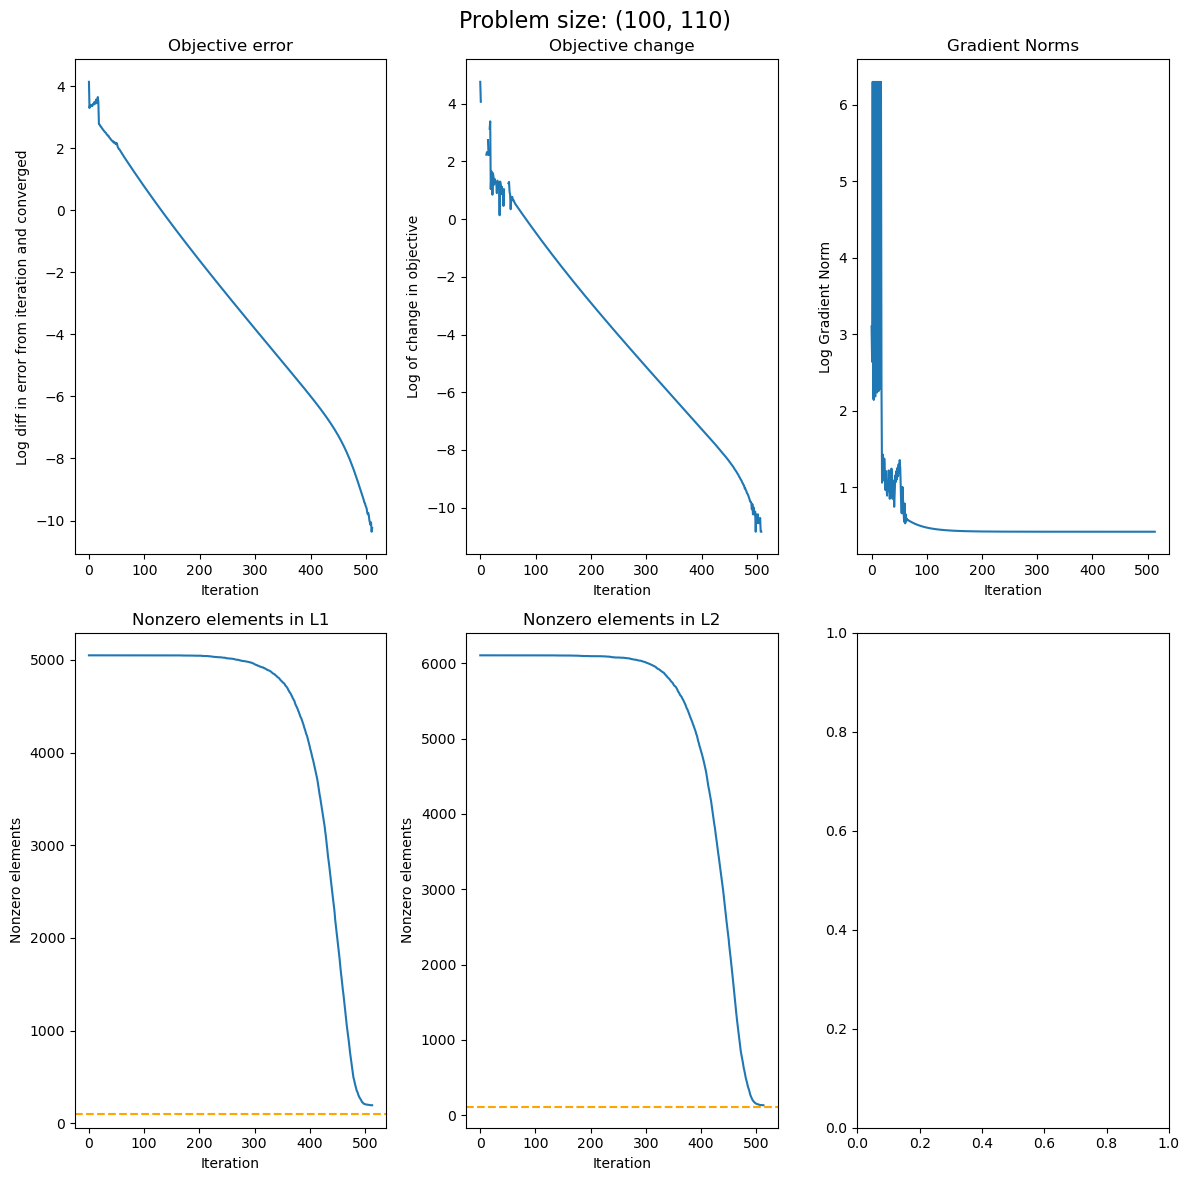

In [ ]:
def proximal_backtracking_line_search(
    f: ObjectiveOracle,
    prox: ProximalOracle,
    P: ProjectionOracle,
    del_f: Direction,
    Ls: list[FactorMatrix],
    init_alpha: StepSize,
    tau: float,
    beta: float
) -> list[FactorMatrix]:
    """
    Backtracking line search
    """
    alpha = init_alpha
    
    cur_f = f(Ls)
    while True:
        new_Ls = prox(P([L - alpha * d for L, d in zip(Ls, del_f)]))
        new_f = f(new_Ls)
        prox_direc = [(L - Lnew) for L, Lnew in zip(Ls, new_Ls)]
        grad_norm = sum([np.linalg.norm(d)**2 for d in prox_direc])
        if new_f <= cur_f - beta * grad_norm / alpha:
            break
        alpha *= tau
        if alpha < 1e-30:
            warnings.warn("Alpha too small, stopping line search")
            return Ls

    return new_Ls

def proximal_accelerated_gradient(
    f: ObjectiveOracle,
    del_f: GradientOracle,
    prox: ProximalOracle,
    P: ProjectionOracle,
    Ls: list[FactorMatrix],
    mu: Momentum,
    init_alpha: StepSize,
    tau: float,
    beta: float,
    max_iter: int = 1000,
    tol: float = 1e-5,
) -> tuple[list[FactorMatrix], Diagnostics]:
    """
    Gradient descent algorithm
    """

    cur_f = f(Ls)

    objs = []
    eps = []
    grads = []
    nonzeros = [[], []]
    
    for i in range(max_iter):
        grad = del_f(Ls)
        if i > 0:
            accelerated_Ls = P([L + mu * (L - old_L) for L, old_L in zip(Ls, oldest_Ls)])
        else:
            accelerated_Ls = Ls
        oldest_Ls = Ls
        Ls = proximal_backtracking_line_search(f, prox, P, grad, accelerated_Ls, init_alpha, tau, beta)

        new_f = f(Ls)
        delta = new_f - cur_f
        objs.append(new_f)
        eps.append(delta)
        grads.append(sum([np.linalg.norm(g) for g in grad]))
        nonzeros[0].append(np.count_nonzero(Ls[0]))
        nonzeros[1].append(np.count_nonzero(Ls[1]))
        
        if np.abs(delta) < tol:
            break
        cur_f = new_f

    return Ls, (objs, eps, grads, nonzeros)


def get_optimizer_oracles(
    X: InputData,
    frobreg: float = 0,
    glassoregs: Optional[tuple[float, float] | float] = None
) -> tuple[ObjectiveOracle, GradientOracle, ProximalOracle]:
    """
    Creates oracles from our input data
    """
    if glassoregs is None:
        glassoregs = [0 for _ in range(X.ndims)]
    if isinstance(glassoregs, float):
        glassoregs = [glassoregs for _ in range(X.ndim)]
    objective: ObjectiveOracle
    def objective(Ls: list[FactorMatrix], decomp=False) -> float:
        if (len(Ls) != 2):
            raise NotImplementedError("Tensor-variate not yet supported")
        L1, L2 = Ls
        trace_term = ((L1 @ X + X @ L2.T)**2).sum()
        log_term = -2 * np.log(np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1)).sum()
        frob_term = frobreg * ((L1**2).sum() + (L2**2).sum())
        differentiable_term = trace_term + log_term + frob_term
        if (np.isnan(differentiable_term)):
            raise ValueError("NaN in differentiable term")
        nondifferentiable_term = sum([glassoregs[i] * np.abs(np.tril(L)).sum() for i, L in enumerate(Ls)])
        if decomp:
            return differentiable_term, nondifferentiable_term
        return differentiable_term + nondifferentiable_term
    
    gradient: GradientOracle
    def gradient(Ls: list[FactorMatrix]) -> Direction:
        if (len(Ls) != 2):
            raise NotImplementedError("Tensor-variate not yet supported")
        L1, L2 = Ls

        trace_term_L1 = np.tril(2 * (L1 @ X @ X.T + X @ L2.T @ X.T), k=0)
        log_term_L1 = - (2  / (np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1))).sum(axis=1)
        grad_L1 = trace_term_L1 + np.diag(log_term_L1) + 2*frobreg*L1

        trace_term_L2 = np.tril(2 * (L2 @ X.T @ X + X.T @ L1 @ X), k=0)
        log_term_L2 = - (2  / (np.diag(L1).reshape(-1, 1) + np.diag(L2).reshape(1, -1))).sum(axis=0)
        grad_L2 = trace_term_L2 + np.diag(log_term_L2) + 2*frobreg*L2

        return [grad_L1, grad_L2]
    
    proximal: ProximalOracle
    def proximal(Ls: list[FactorMatrix]) -> list[FactorMatrix]:
        """
        Soft thresholding on each of the Ls, not affecting their diagonals
        """
        new_Ls = []
        for i, L in enumerate(Ls):
            L_diag = np.diag(L)
            new_L = np.sign(L) * np.maximum(np.abs(L) - glassoregs[i], 0)
            np.fill_diagonal(new_L, L_diag)
            new_Ls.append(new_L)
        return new_Ls
    
    return objective, gradient, proximal

project_to_lower_with_positive_diag: Projection
def project_to_lower_with_positive_diag(Ms: list[FactorMatrix], tol=1e-6) -> list[FactorMatrix]:
    """
    Project M to strictly lower-triangular + positive diagonal
    """

    Ls = []
    for M in Ms:
        L = np.tril(M)
        np.fill_diagonal(L, np.maximum(np.diag(L), tol))  # Ensure positive diag
        Ls.append(L)
    return Ls

np.random.seed(1)
n = (100, 110)

L1_star = np.tril(np.random.randn(n[0], n[0]))
L2_star = np.tril(np.random.randn(n[1], n[1]))
X = linalg.solve_sylvester(L1_star, L2_star, np.random.normal(size=n))
X /= np.linalg.norm(X, ord=2)
print("Data generated")

L1_init = np.tril(np.random.randn(n[0], n[0]))
np.fill_diagonal(L1_init, np.abs(np.diag(L1_init)) + 1.0)
L2_init = np.tril(np.random.randn(n[1], n[1]))
np.fill_diagonal(L2_init, np.abs(np.diag(L2_init)) + 1.0)
L_init = [L1_init, L2_init]

frobreg = 1/np.prod(n)**(1/len(n))
glassoreg = 0.5e-6
objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

Ls, (objs, eps, grads, nonzeros) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=5000,
    tol=1e-20
)

# Plot convergence
fig, ((ax1, ax2, ax3), (ax4, ax5, _)) = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
ax1.plot(np.log10(np.array(objs) - min(objs)))
ax1.set_title("Objective error")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Log diff in error from iteration and converged")
ax2.plot(np.log10(-np.array(eps)))
ax2.set_title("Objective change")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Log of change in objective")
ax3.plot(np.log10(np.array(grads)))
ax3.set_title("Gradient Norms")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Log Gradient Norm")
ax4.plot(nonzeros[0])
ax4.set_title("Nonzero elements in L1")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Nonzero elements")
ax4.axhline(y=n[0], color='orange', linestyle='--')
ax5.plot(nonzeros[1])
ax5.set_title("Nonzero elements in L2")
ax5.set_xlabel("Iteration")
ax5.set_ylabel("Nonzero elements")
ax5.axhline(y=n[1], color='orange', linestyle='--')
fig.suptitle(f"Problem size: {n}", fontsize=16)
fig.tight_layout()

Data generated
L1 Param: 1e-05
L1 Param: 1.1497569953977357e-05
L1 Param: 1.3219411484660286e-05
L1 Param: 1.5199110829529332e-05
L1 Param: 1.747528400007683e-05
L1 Param: 2.0092330025650458e-05
L1 Param: 2.310129700083158e-05
L1 Param: 2.656087782946684e-05
L1 Param: 3.053855508833412e-05
L1 Param: 3.511191734215127e-05
L1 Param: 4.03701725859655e-05
L1 Param: 4.641588833612772e-05
L1 Param: 5.3366992312063123e-05
L1 Param: 6.135907273413175e-05
L1 Param: 7.054802310718646e-05
L1 Param: 8.111308307896872e-05
L1 Param: 9.326033468832199e-05
L1 Param: 0.00010722672220103231


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2892859598.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 0.0001232846739442066
L1 Param: 0.00014174741629268049
L1 Param: 0.00016297508346206434
L1 Param: 0.0001873817422860383
L1 Param: 0.00021544346900318823
L1 Param: 0.0002477076355991709
L1 Param: 0.0002848035868435799
L1 Param: 0.0003274549162877725
L1 Param: 0.0003764935806792464
L1 Param: 0.00043287612810830614
L1 Param: 0.0004977023564332114
L1 Param: 0.0005722367659350221
L1 Param: 0.0006579332246575682
L1 Param: 0.000756463327554629
L1 Param: 0.0008697490026177834
L1 Param: 0.001
L1 Param: 0.0011497569953977356
L1 Param: 0.0013219411484660286
L1 Param: 0.0015199110829529332
L1 Param: 0.001747528400007683
L1 Param: 0.002009233002565046
L1 Param: 0.002310129700083158
L1 Param: 0.0026560877829466868
L1 Param: 0.0030538555088334154
L1 Param: 0.003511191734215131
L1 Param: 0.004037017258596553
L1 Param: 0.004641588833612777
L1 Param: 0.005336699231206307
L1 Param: 0.006135907273413169
L1 Param: 0.007054802310718645
L1 Param: 0.008111308307896872
L1 Param: 0.0093260334688322
L1

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/1388792428.py:77: RuntimeWarning: invalid value encountered in scalar divide
  L1_precision = [(L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern_estim[i]).sum() for i in range(len(Lss))]
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/1388792428.py:78: RuntimeWarning: invalid value encountered in scalar divide
  L2_precision = [(L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern_estim[i]).sum() for i in range(len(Lss))]


(0.0, 1.0)

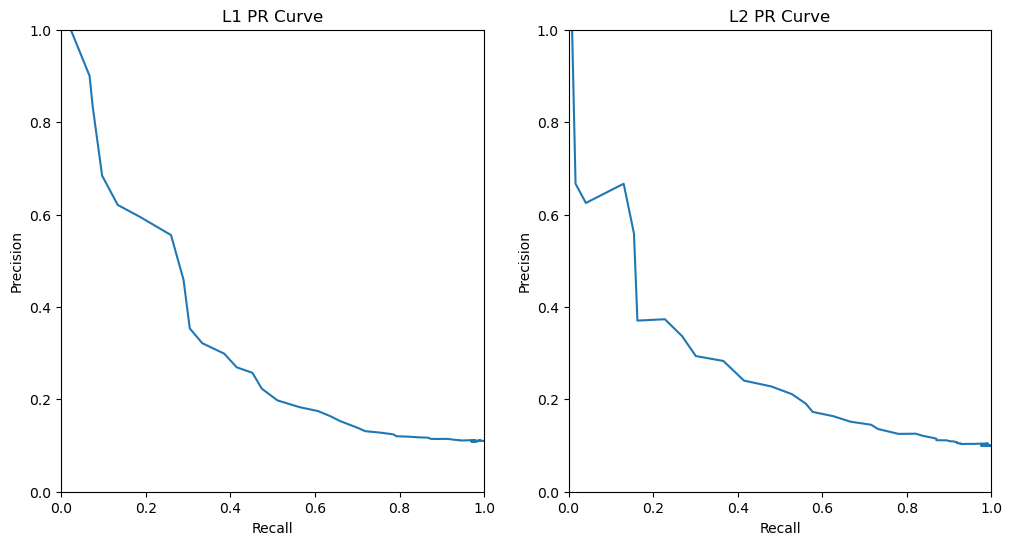

In [359]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (50, 50)

L1_star = np.tril(np.random.randn(n[0], n[0]))
L2_star = np.tril(np.random.randn(n[1], n[1]))
# generate bernoulli sparsity pattern
L1_star[np.random.rand(*L1_star.shape) > 0.1] = 0
L2_star[np.random.rand(*L2_star.shape) > 0.1] = 0
L1_pattern = (np.abs(np.tril(L1_star, k=-1)) > 1e-16)
L2_pattern = (np.abs(np.tril(L2_star, k=-1)) > 1e-16)
np.fill_diagonal(L1_star, np.abs(np.diag(L1_star))+2)
np.fill_diagonal(L2_star, np.abs(np.diag(L2_star))+2)
X = linalg.solve_sylvester(L1_star, L2_star, np.random.normal(size=n))
X /= np.linalg.norm(X, ord=2)
print("Data generated")

L1_init = np.tril(np.random.randn(n[0], n[0]))
np.fill_diagonal(L1_init, np.abs(np.diag(L1_init)) + 1.0)
L2_init = np.tril(np.random.randn(n[1], n[1]))
np.fill_diagonal(L2_init, np.abs(np.diag(L2_init)) + 1.0)
L_init = [L1_init, L2_init]
glassoregs = np.logspace(1, -5, 100)[::-1]
Lss, diags = warm_start(X, L_init, glassoregs=glassoregs)
print("Model fit")

L1_pattern_estim = [(np.abs(Ls[0]) > 1e-16) for Ls in Lss]
L2_pattern_estim = [(np.abs(Ls[1]) > 1e-16) for Ls in Lss]

# Remove diagonals
np.fill_diagonal(L1_pattern, 0)
np.fill_diagonal(L2_pattern, 0)
for i in range(len(Lss)):
    np.fill_diagonal(L1_pattern_estim[i], 0)
    np.fill_diagonal(L2_pattern_estim[i], 0)

L1_precision = [(L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern_estim[i]).sum() for i in range(len(Lss))]
L2_precision = [(L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern_estim[i]).sum() for i in range(len(Lss))]
L1_precision = [p if not np.isinf(p) else 1 for p in L1_precision]
L2_precision = [p if not np.isinf(p) else 1 for p in L2_precision]
L1_recall = [(L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern).sum() for i in range(len(Lss))]
L2_recall = [(L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern).sum() for i in range(len(Lss))]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
print(L1_precision)
print(L1_recall)
print([L.sum() for L in L1_pattern_estim])
ax1.plot(L1_recall, L1_precision)
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title("L1 PR Curve")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax2.plot(L2_recall, L2_precision)
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("L2 PR Curve")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

Data generated
L1 Param: 3.1622776601683795


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2892859598.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 2.8117686979742307
L1 Param: 2.50011038261793
L1 Param: 2.2229964825261948
L1 Param: 1.9765980717016338
L1 Param: 1.7575106248547918
L1 Param: 1.5627069765469952
L1 Param: 1.3894954943731377
L1 Param: 1.235482888256747
L1 Param: 1.0985411419875581
L1 Param: 0.976778110089489
L1 Param: 0.8685113737513525
L1 Param: 0.7722449945836258
L1 Param: 0.6866488450043002
L1 Param: 0.6105402296585328
L1 Param: 0.5428675439323859
L1 Param: 0.4826957437677871
L1 Param: 0.42919342601287785
L1 Param: 0.3816213407949356
L1 Param: 0.3393221771895328
L1 Param: 0.3017114810529294
L1 Param: 0.2682695795279726
L1 Param: 0.23853440064314188
L1 Param: 0.21209508879201905
L1 Param: 0.18858632787726495
L1 Param: 0.16768329368110083
L1 Param: 0.14909716571840645
L1 Param: 0.13257113655901087
L1 Param: 0.11787686347935872
L1 Param: 0.10481131341546858
L1 Param: 0.09319395762340775
L1 Param: 0.08286427728546843
L1 Param: 0.0736795455966163
L1 Param: 0.0655128556859551
L1 Param: 0.05825136712468927
L1 Par

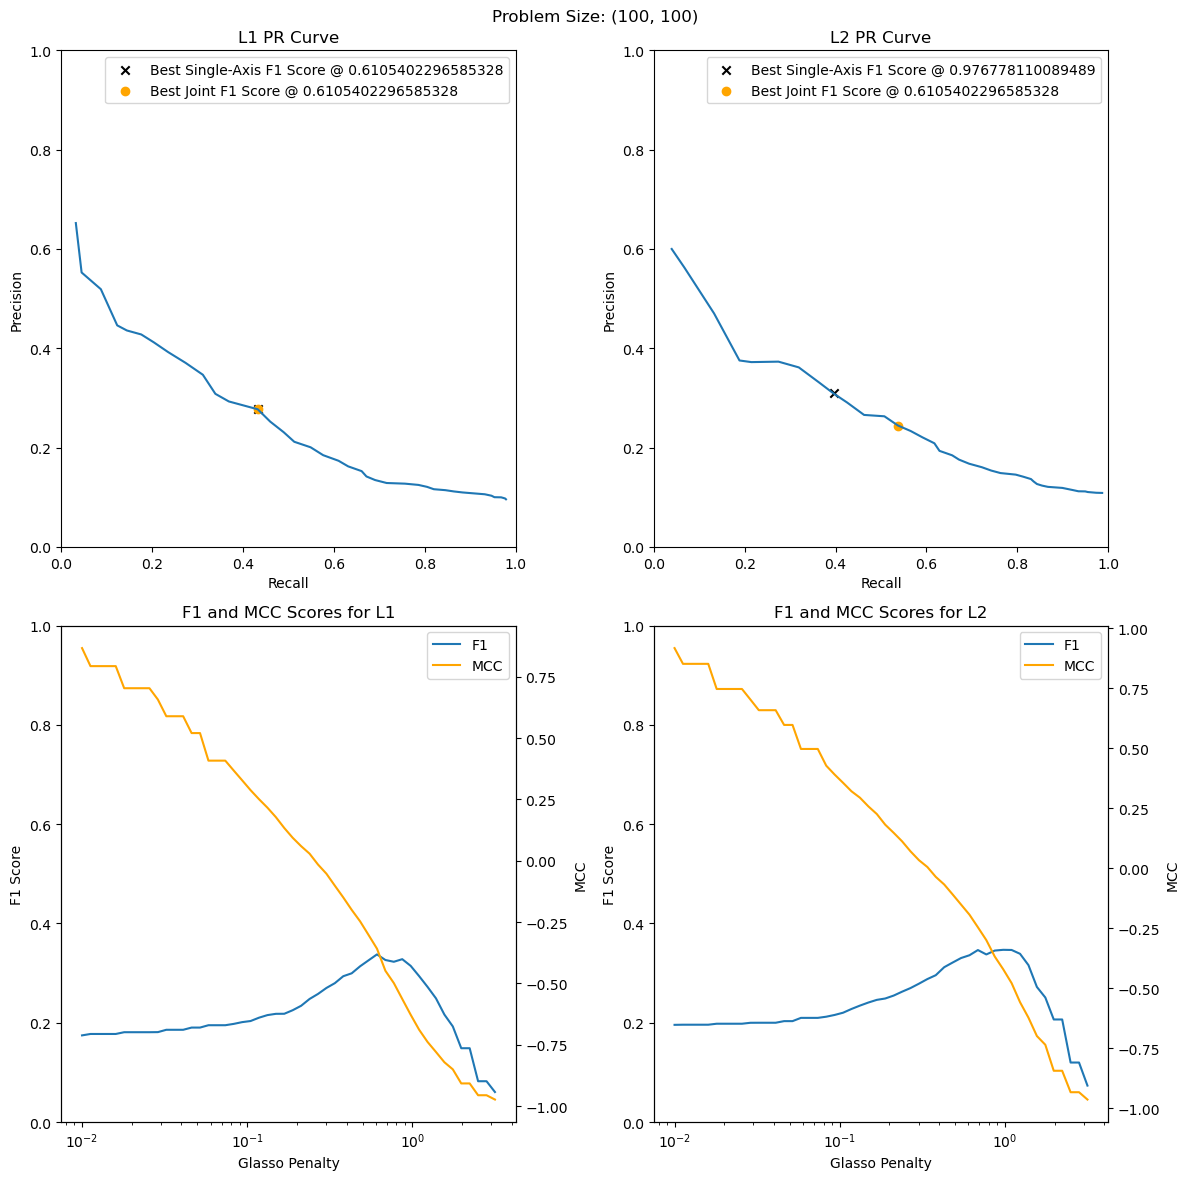

In [416]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (100, 100)

L1_star = np.tril(np.random.randn(n[0], n[0]))
L2_star = np.tril(np.random.randn(n[1], n[1]))
# generate bernoulli sparsity pattern
L1_star[np.random.rand(*L1_star.shape) > 0.1] = 0
L2_star[np.random.rand(*L2_star.shape) > 0.1] = 0
L1_pattern = (np.abs(np.tril(L1_star, k=-1)) > 1e-16)
L2_pattern = (np.abs(np.tril(L2_star, k=-1)) > 1e-16)
np.fill_diagonal(L1_star, 2)
np.fill_diagonal(L2_star, 2)
X = linalg.solve_sylvester(L1_star, L2_star, np.random.normal(size=n))
X /= np.linalg.norm(X, ord=2)
print("Data generated")

L1_init = np.tril(np.random.randn(n[0], n[0]))
np.fill_diagonal(L1_init, np.abs(np.diag(L1_init)) + 1.0)
L2_init = np.tril(np.random.randn(n[1], n[1]))
np.fill_diagonal(L2_init, np.abs(np.diag(L2_init)) + 1.0)
L_init = [L1_init, L2_init]
#glassoregs = np.logspace(1, -2, 50) # (50, 50)
#glassoregs = np.logspace(1, -1, 50) # (75, 75)
glassoregs = np.logspace(0.5, -2, 50) # (100, 100)
Lss, diags = warm_start(X, L_init, glassoregs=glassoregs)
print("Model fit")

L1_pattern_estim = [(np.abs(Ls[0]) > 1e-16) for Ls in Lss]
L2_pattern_estim = [(np.abs(Ls[1]) > 1e-16) for Ls in Lss]

# Remove diagonals
np.fill_diagonal(L1_pattern, 0)
np.fill_diagonal(L2_pattern, 0)
for i in range(len(Lss)):
    np.fill_diagonal(L1_pattern_estim[i], 0)
    np.fill_diagonal(L2_pattern_estim[i], 0)

L1_precision = [
    ((L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern_estim[i]).sum())
    if (L1_pattern_estim[i]).sum() != 0
    else 1
    for i in range(len(Lss))
]
L2_precision = [
    (L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern_estim[i]).sum()
    if (L2_pattern_estim[i]).sum() != 0
    else 1
    for i in range(len(Lss))
]
L1_precision = [p if not np.isinf(p) else 1 for p in L1_precision]
L2_precision = [p if not np.isinf(p) else 1 for p in L2_precision]
L1_recall = [(L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern).sum() for i in range(len(Lss))]
L2_recall = [(L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern).sum() for i in range(len(Lss))]

# Compute F1 and MCC
L1_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(L1_precision, L1_recall)]
L2_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(L2_precision, L2_recall)]
L1_TP = [np.tril(L1_pattern & L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_FP = [np.tril(L1_pattern & ~L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_TN = [np.tril(~L1_pattern & L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_FN = [np.tril(~L1_pattern & ~L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(L1_TP, L1_TN, L1_FP, L1_FN)
]
L2_TP = [np.tril(L2_pattern & L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_FP = [np.tril(L2_pattern & ~L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_TN = [np.tril(~L2_pattern & L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_FN = [np.tril(~L2_pattern & ~L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(L2_TP, L2_TN, L2_FP, L2_FN)
]

L1_maxF1 = np.argmax(L1_F1)
L2_maxF1 = np.argmax(L2_F1)
Ls_maxF1 = np.argmax(np.array(L1_F1) + np.array(L2_F1))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
ax1.plot(L1_recall, L1_precision)
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title("L1 PR Curve")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.scatter(L1_recall[L1_maxF1], L1_precision[L1_maxF1], marker='x', color='black', label=f"Best Single-Axis F1 Score @ {glassoregs[L1_maxF1]}")
ax1.scatter(L1_recall[Ls_maxF1], L1_precision[Ls_maxF1], marker='o', color='orange', label=f"Best Joint F1 Score @ {glassoregs[Ls_maxF1]}")
ax1.legend()
ax2.plot(L2_recall, L2_precision)
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("L2 PR Curve")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.scatter(L2_recall[L2_maxF1], L2_precision[L2_maxF1], marker='x', color='black', label=f"Best Single-Axis F1 Score @ {glassoregs[L2_maxF1]}")
ax2.scatter(L2_recall[Ls_maxF1], L2_precision[Ls_maxF1], marker='o', color='orange', label=f"Best Joint F1 Score @ {glassoregs[Ls_maxF1]}")
ax2.legend()
f1, = ax3.plot(glassoregs, L1_F1, label="F1")
ax3.set_xlabel("Glasso Penalty")
ax3.set_ylabel("F1 Score")
ax3.set_title("F1 and MCC Scores for L1")
ax3.set_ylim(0, 1)
ax3.set_xscale('log')
tax3 = ax3.twinx()
mcc, = tax3.plot(glassoregs, L1_MCC, label="MCC", color="orange")
tax3.set_ylabel("MCC")
tax3.legend([f1,mcc], [f1.get_label(), mcc.get_label()])
f1, = ax4.plot(glassoregs, L2_F1, label="F1")
ax4.set_xlabel("Glasso Penalty")
ax4.set_ylabel("F1 Score")
ax4.set_title("F1 and MCC Scores for L2")
ax4.set_ylim(0, 1)
ax4.set_xscale('log')
tax4 = ax4.twinx()
mcc, = tax4.plot(glassoregs, L2_MCC, label="MCC", color="orange")
tax4.set_ylabel("MCC")
tax4.legend([f1,mcc], [f1.get_label(), mcc.get_label()])
fig.suptitle(f"Problem Size: {n}")
fig.tight_layout()

Data generated
L1 Param: 3.1622776601683795


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2892859598.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 2.8117686979742307
L1 Param: 2.50011038261793
L1 Param: 2.2229964825261948
L1 Param: 1.9765980717016338
L1 Param: 1.7575106248547918
L1 Param: 1.5627069765469952
L1 Param: 1.3894954943731377
L1 Param: 1.235482888256747
L1 Param: 1.0985411419875581
L1 Param: 0.976778110089489
L1 Param: 0.8685113737513525
L1 Param: 0.7722449945836258
L1 Param: 0.6866488450043002
L1 Param: 0.6105402296585328
L1 Param: 0.5428675439323859
L1 Param: 0.4826957437677871
L1 Param: 0.42919342601287785
L1 Param: 0.3816213407949356
L1 Param: 0.3393221771895328
L1 Param: 0.3017114810529294
L1 Param: 0.2682695795279726
L1 Param: 0.23853440064314188
L1 Param: 0.21209508879201905
L1 Param: 0.18858632787726495
L1 Param: 0.16768329368110083
L1 Param: 0.14909716571840645
L1 Param: 0.13257113655901087
L1 Param: 0.11787686347935872
L1 Param: 0.10481131341546858
L1 Param: 0.09319395762340775
L1 Param: 0.08286427728546843
L1 Param: 0.0736795455966163
L1 Param: 0.0655128556859551
L1 Param: 0.05825136712468927
L1 Par

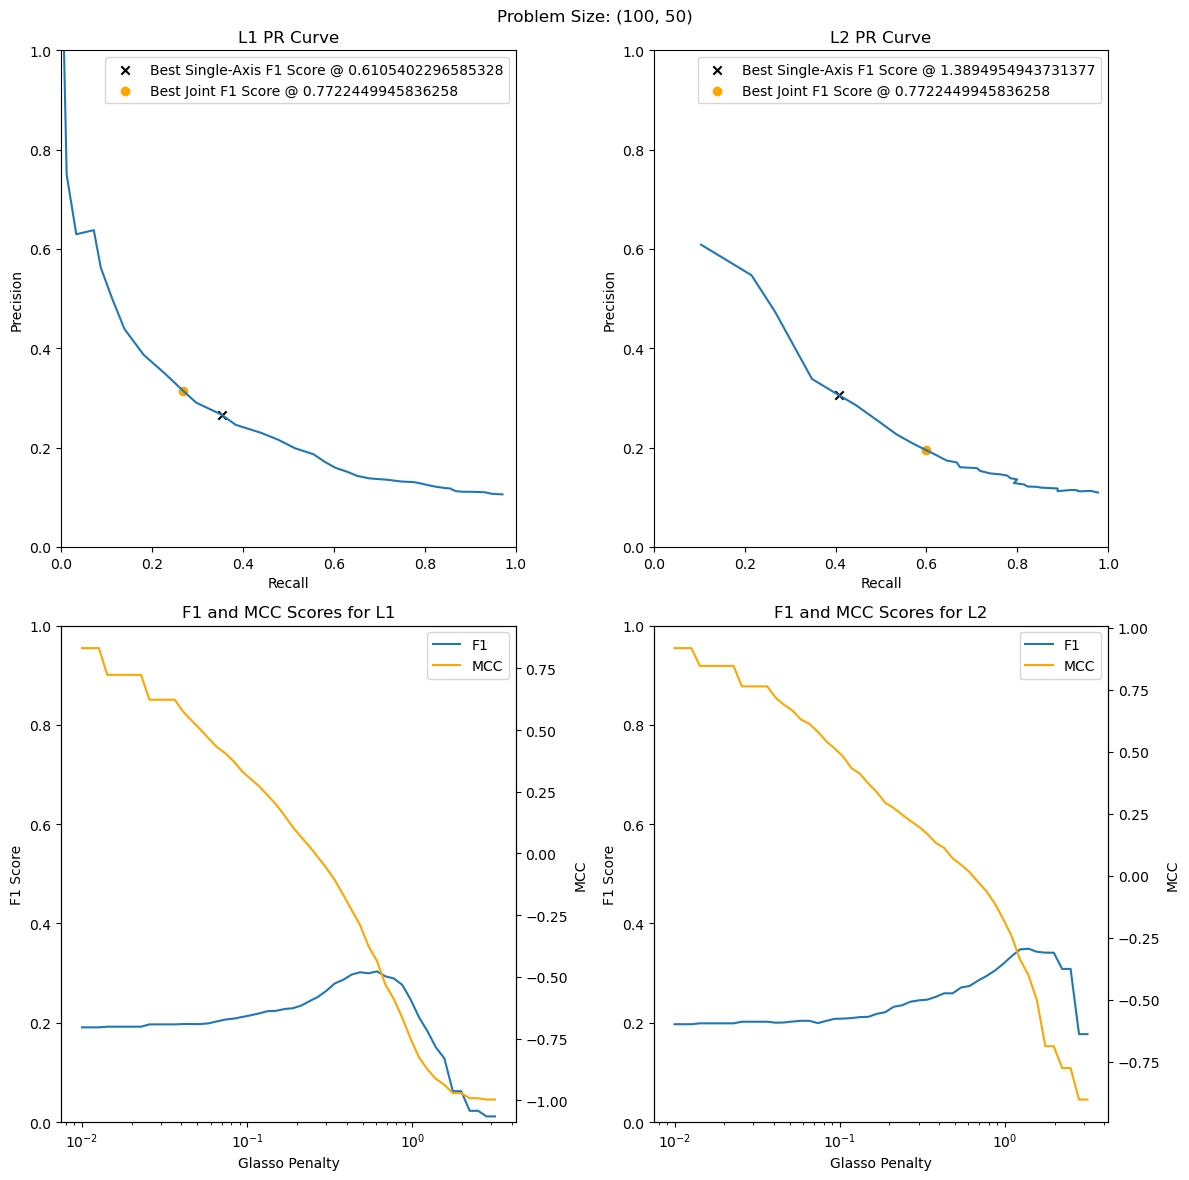

In [417]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (100, 50)

L1_star = np.tril(np.random.randn(n[0], n[0]))
L2_star = np.tril(np.random.randn(n[1], n[1]))
# generate bernoulli sparsity pattern
L1_star[np.random.rand(*L1_star.shape) > 0.1] = 0
L2_star[np.random.rand(*L2_star.shape) > 0.1] = 0
L1_pattern = (np.abs(np.tril(L1_star, k=-1)) > 1e-16)
L2_pattern = (np.abs(np.tril(L2_star, k=-1)) > 1e-16)
np.fill_diagonal(L1_star, 2)
np.fill_diagonal(L2_star, 2)
X = linalg.solve_sylvester(L1_star, L2_star, np.random.normal(size=n))
X /= np.linalg.norm(X, ord=2)
print("Data generated")

L1_init = np.tril(np.random.randn(n[0], n[0]))
np.fill_diagonal(L1_init, np.abs(np.diag(L1_init)) + 1.0)
L2_init = np.tril(np.random.randn(n[1], n[1]))
np.fill_diagonal(L2_init, np.abs(np.diag(L2_init)) + 1.0)
L_init = [L1_init, L2_init]
#glassoregs = np.logspace(1, -2, 50) # (50, 50)
#glassoregs = np.logspace(1, -1, 50) # (75, 75)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 100)
glassoregs = np.logspace(0.5, -2, 50) # (100, 50)
Lss, diags = warm_start(X, L_init, glassoregs=glassoregs)
print("Model fit")

L1_pattern_estim = [(np.abs(Ls[0]) > 1e-16) for Ls in Lss]
L2_pattern_estim = [(np.abs(Ls[1]) > 1e-16) for Ls in Lss]

# Remove diagonals
np.fill_diagonal(L1_pattern, 0)
np.fill_diagonal(L2_pattern, 0)
for i in range(len(Lss)):
    np.fill_diagonal(L1_pattern_estim[i], 0)
    np.fill_diagonal(L2_pattern_estim[i], 0)

L1_precision = [
    ((L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern_estim[i]).sum())
    if (L1_pattern_estim[i]).sum() != 0
    else 1
    for i in range(len(Lss))
]
L2_precision = [
    (L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern_estim[i]).sum()
    if (L2_pattern_estim[i]).sum() != 0
    else 1
    for i in range(len(Lss))
]
L1_precision = [p if not np.isinf(p) else 1 for p in L1_precision]
L2_precision = [p if not np.isinf(p) else 1 for p in L2_precision]
L1_recall = [(L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern).sum() for i in range(len(Lss))]
L2_recall = [(L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern).sum() for i in range(len(Lss))]

# Compute F1 and MCC
L1_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(L1_precision, L1_recall)]
L2_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(L2_precision, L2_recall)]
L1_TP = [np.tril(L1_pattern & L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_FP = [np.tril(L1_pattern & ~L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_TN = [np.tril(~L1_pattern & L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_FN = [np.tril(~L1_pattern & ~L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(L1_TP, L1_TN, L1_FP, L1_FN)
]
L2_TP = [np.tril(L2_pattern & L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_FP = [np.tril(L2_pattern & ~L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_TN = [np.tril(~L2_pattern & L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_FN = [np.tril(~L2_pattern & ~L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(L2_TP, L2_TN, L2_FP, L2_FN)
]

L1_maxF1 = np.argmax(L1_F1)
L2_maxF1 = np.argmax(L2_F1)
Ls_maxF1 = np.argmax(np.array(L1_F1) + np.array(L2_F1))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
ax1.plot(L1_recall, L1_precision)
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title("L1 PR Curve")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.scatter(L1_recall[L1_maxF1], L1_precision[L1_maxF1], marker='x', color='black', label=f"Best Single-Axis F1 Score @ {glassoregs[L1_maxF1]}")
ax1.scatter(L1_recall[Ls_maxF1], L1_precision[Ls_maxF1], marker='o', color='orange', label=f"Best Joint F1 Score @ {glassoregs[Ls_maxF1]}")
ax1.legend()
ax2.plot(L2_recall, L2_precision)
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("L2 PR Curve")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.scatter(L2_recall[L2_maxF1], L2_precision[L2_maxF1], marker='x', color='black', label=f"Best Single-Axis F1 Score @ {glassoregs[L2_maxF1]}")
ax2.scatter(L2_recall[Ls_maxF1], L2_precision[Ls_maxF1], marker='o', color='orange', label=f"Best Joint F1 Score @ {glassoregs[Ls_maxF1]}")
ax2.legend()
f1, = ax3.plot(glassoregs, L1_F1, label="F1")
ax3.set_xlabel("Glasso Penalty")
ax3.set_ylabel("F1 Score")
ax3.set_title("F1 and MCC Scores for L1")
ax3.set_ylim(0, 1)
ax3.set_xscale('log')
tax3 = ax3.twinx()
mcc, = tax3.plot(glassoregs, L1_MCC, label="MCC", color="orange")
tax3.set_ylabel("MCC")
tax3.legend([f1,mcc], [f1.get_label(), mcc.get_label()])
f1, = ax4.plot(glassoregs, L2_F1, label="F1")
ax4.set_xlabel("Glasso Penalty")
ax4.set_ylabel("F1 Score")
ax4.set_title("F1 and MCC Scores for L2")
ax4.set_ylim(0, 1)
ax4.set_xscale('log')
tax4 = ax4.twinx()
mcc, = tax4.plot(glassoregs, L2_MCC, label="MCC", color="orange")
tax4.set_ylabel("MCC")
tax4.legend([f1,mcc], [f1.get_label(), mcc.get_label()])
fig.suptitle(f"Problem Size: {n}")
fig.tight_layout()

Data generated
L1 Param: 3.1622776601683795


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2892859598.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 2.8117686979742307
L1 Param: 2.50011038261793
L1 Param: 2.2229964825261948
L1 Param: 1.9765980717016338
L1 Param: 1.7575106248547918
L1 Param: 1.5627069765469952
L1 Param: 1.3894954943731377
L1 Param: 1.235482888256747
L1 Param: 1.0985411419875581
L1 Param: 0.976778110089489
L1 Param: 0.8685113737513525
L1 Param: 0.7722449945836258
L1 Param: 0.6866488450043002
L1 Param: 0.6105402296585328
L1 Param: 0.5428675439323859
L1 Param: 0.4826957437677871
L1 Param: 0.42919342601287785
L1 Param: 0.3816213407949356
L1 Param: 0.3393221771895328
L1 Param: 0.3017114810529294
L1 Param: 0.2682695795279726
L1 Param: 0.23853440064314188
L1 Param: 0.21209508879201905
L1 Param: 0.18858632787726495
L1 Param: 0.16768329368110083
L1 Param: 0.14909716571840645
L1 Param: 0.13257113655901087
L1 Param: 0.11787686347935872
L1 Param: 0.10481131341546858
L1 Param: 0.09319395762340775
L1 Param: 0.08286427728546843
L1 Param: 0.0736795455966163
L1 Param: 0.0655128556859551
L1 Param: 0.05825136712468927
L1 Par

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2717820390.py:95: RuntimeWarning: invalid value encountered in scalar divide
  L2_recall = [(L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern).sum() for i in range(len(Lss))]
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/2717820390.py:113: RuntimeWarning: invalid value encountered in scalar divide
  (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))


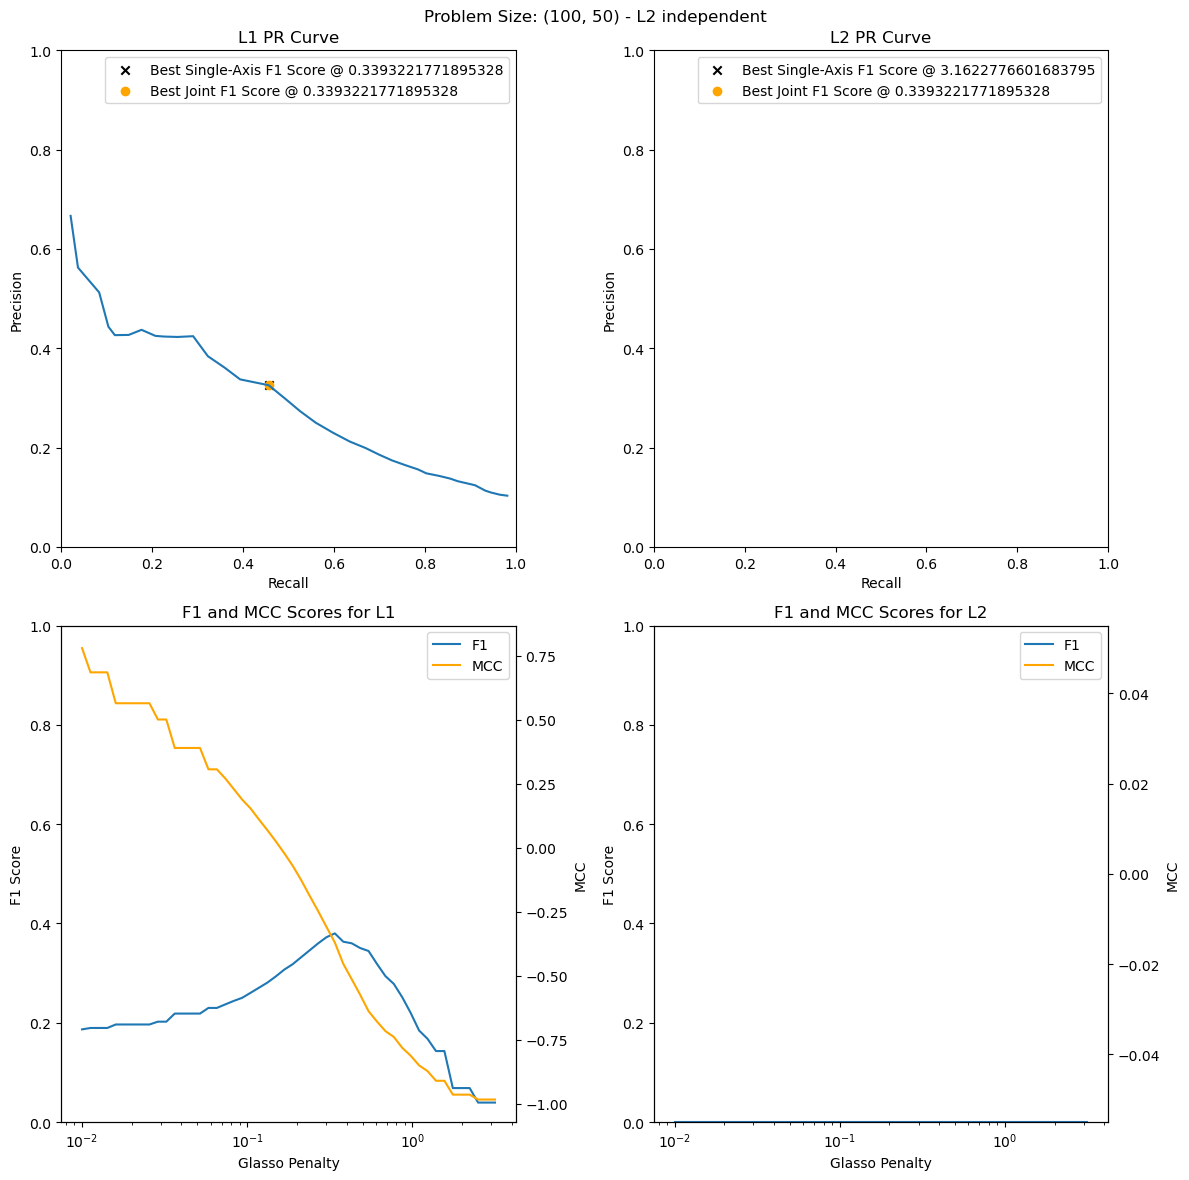

In [419]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (100, 50)

L1_star = np.tril(np.random.randn(n[0], n[0]))
L2_star = 0*np.eye(n[1])#np.tril(np.random.randn(n[1], n[1]))
# generate bernoulli sparsity pattern
L1_star[np.random.rand(*L1_star.shape) > 0.1] = 0
L2_star[np.random.rand(*L2_star.shape) > 0.1] = 0
L1_pattern = (np.abs(np.tril(L1_star, k=-1)) > 1e-16)
L2_pattern = (np.abs(np.tril(L2_star, k=-1)) > 1e-16)
np.fill_diagonal(L1_star, 2)
#np.fill_diagonal(L2_star, 2)
X = linalg.solve_sylvester(L1_star, L2_star, np.random.normal(size=n))
X /= np.linalg.norm(X, ord=2)
print("Data generated")

L1_init = np.tril(np.random.randn(n[0], n[0]))
np.fill_diagonal(L1_init, np.abs(np.diag(L1_init)) + 1.0)
L2_init = np.tril(np.random.randn(n[1], n[1]))
np.fill_diagonal(L2_init, np.abs(np.diag(L2_init)) + 1.0)
L_init = [L1_init, L2_init]
#glassoregs = np.logspace(1, -2, 50) # (50, 50)
#glassoregs = np.logspace(1, -1, 50) # (75, 75)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 100)
glassoregs = np.logspace(0.5, -2, 50) # (100, 50)
Lss, diags = warm_start(X, L_init, glassoregs=glassoregs)
print("Model fit")

L1_pattern_estim = [(np.abs(Ls[0]) > 1e-16) for Ls in Lss]
L2_pattern_estim = [(np.abs(Ls[1]) > 1e-16) for Ls in Lss]

# Remove diagonals
np.fill_diagonal(L1_pattern, 0)
np.fill_diagonal(L2_pattern, 0)
for i in range(len(Lss)):
    np.fill_diagonal(L1_pattern_estim[i], 0)
    np.fill_diagonal(L2_pattern_estim[i], 0)

L1_precision = [
    ((L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern_estim[i]).sum())
    if (L1_pattern_estim[i]).sum() != 0
    else 1
    for i in range(len(Lss))
]
L2_precision = [
    (L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern_estim[i]).sum()
    if (L2_pattern_estim[i]).sum() != 0
    else 1
    for i in range(len(Lss))
]
L1_precision = [p if not np.isinf(p) else 1 for p in L1_precision]
L2_precision = [p if not np.isinf(p) else 1 for p in L2_precision]
L1_recall = [(L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern).sum() for i in range(len(Lss))]
L2_recall = [(L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern).sum() for i in range(len(Lss))]

# Compute F1 and MCC
L1_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(L1_precision, L1_recall)]
L2_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(L2_precision, L2_recall)]
L1_TP = [np.tril(L1_pattern & L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_FP = [np.tril(L1_pattern & ~L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_TN = [np.tril(~L1_pattern & L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_FN = [np.tril(~L1_pattern & ~L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(L1_TP, L1_TN, L1_FP, L1_FN)
]
L2_TP = [np.tril(L2_pattern & L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_FP = [np.tril(L2_pattern & ~L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_TN = [np.tril(~L2_pattern & L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_FN = [np.tril(~L2_pattern & ~L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(L2_TP, L2_TN, L2_FP, L2_FN)
]

L1_maxF1 = np.argmax(L1_F1)
L2_maxF1 = np.argmax(L2_F1)
Ls_maxF1 = np.argmax(np.array(L1_F1) + np.array(L2_F1))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
ax1.plot(L1_recall, L1_precision)
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title("L1 PR Curve")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.scatter(L1_recall[L1_maxF1], L1_precision[L1_maxF1], marker='x', color='black', label=f"Best Single-Axis F1 Score @ {glassoregs[L1_maxF1]}")
ax1.scatter(L1_recall[Ls_maxF1], L1_precision[Ls_maxF1], marker='o', color='orange', label=f"Best Joint F1 Score @ {glassoregs[Ls_maxF1]}")
ax1.legend()
ax2.plot(L2_recall, L2_precision)
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("L2 PR Curve")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.scatter(L2_recall[L2_maxF1], L2_precision[L2_maxF1], marker='x', color='black', label=f"Best Single-Axis F1 Score @ {glassoregs[L2_maxF1]}")
ax2.scatter(L2_recall[Ls_maxF1], L2_precision[Ls_maxF1], marker='o', color='orange', label=f"Best Joint F1 Score @ {glassoregs[Ls_maxF1]}")
ax2.legend()
f1, = ax3.plot(glassoregs, L1_F1, label="F1")
ax3.set_xlabel("Glasso Penalty")
ax3.set_ylabel("F1 Score")
ax3.set_title("F1 and MCC Scores for L1")
ax3.set_ylim(0, 1)
ax3.set_xscale('log')
tax3 = ax3.twinx()
mcc, = tax3.plot(glassoregs, L1_MCC, label="MCC", color="orange")
tax3.set_ylabel("MCC")
tax3.legend([f1,mcc], [f1.get_label(), mcc.get_label()])
f1, = ax4.plot(glassoregs, L2_F1, label="F1")
ax4.set_xlabel("Glasso Penalty")
ax4.set_ylabel("F1 Score")
ax4.set_title("F1 and MCC Scores for L2")
ax4.set_ylim(0, 1)
ax4.set_xscale('log')
tax4 = ax4.twinx()
mcc, = tax4.plot(glassoregs, L2_MCC, label="MCC", color="orange")
tax4.set_ylabel("MCC")
tax4.legend([f1,mcc], [f1.get_label(), mcc.get_label()])
fig.suptitle(f"Problem Size: {n} - L2 independent")
fig.tight_layout()

Data generated
L1 Param: 3.1622776601683795


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/3950260077.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 2.8117686979742307
L1 Param: 2.50011038261793
L1 Param: 2.2229964825261948
L1 Param: 1.9765980717016338
L1 Param: 1.7575106248547918
L1 Param: 1.5627069765469952
L1 Param: 1.3894954943731377
L1 Param: 1.235482888256747
L1 Param: 1.0985411419875581
L1 Param: 0.976778110089489
L1 Param: 0.8685113737513525
L1 Param: 0.7722449945836258
L1 Param: 0.6866488450043002
L1 Param: 0.6105402296585328
L1 Param: 0.5428675439323859
L1 Param: 0.4826957437677871
L1 Param: 0.42919342601287785
L1 Param: 0.3816213407949356
L1 Param: 0.3393221771895328
L1 Param: 0.3017114810529294
L1 Param: 0.2682695795279726
L1 Param: 0.23853440064314188
L1 Param: 0.21209508879201905
L1 Param: 0.18858632787726495
L1 Param: 0.16768329368110083
L1 Param: 0.14909716571840645
L1 Param: 0.13257113655901087
L1 Param: 0.11787686347935872
L1 Param: 0.10481131341546858
L1 Param: 0.09319395762340775
L1 Param: 0.08286427728546843
L1 Param: 0.0736795455966163
L1 Param: 0.0655128556859551
L1 Param: 0.05825136712468927
L1 Par

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/4178780928.py:95: RuntimeWarning: invalid value encountered in scalar divide
  L2_recall = [(L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern).sum() for i in range(len(Lss))]
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/4178780928.py:113: RuntimeWarning: invalid value encountered in scalar divide
  (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))


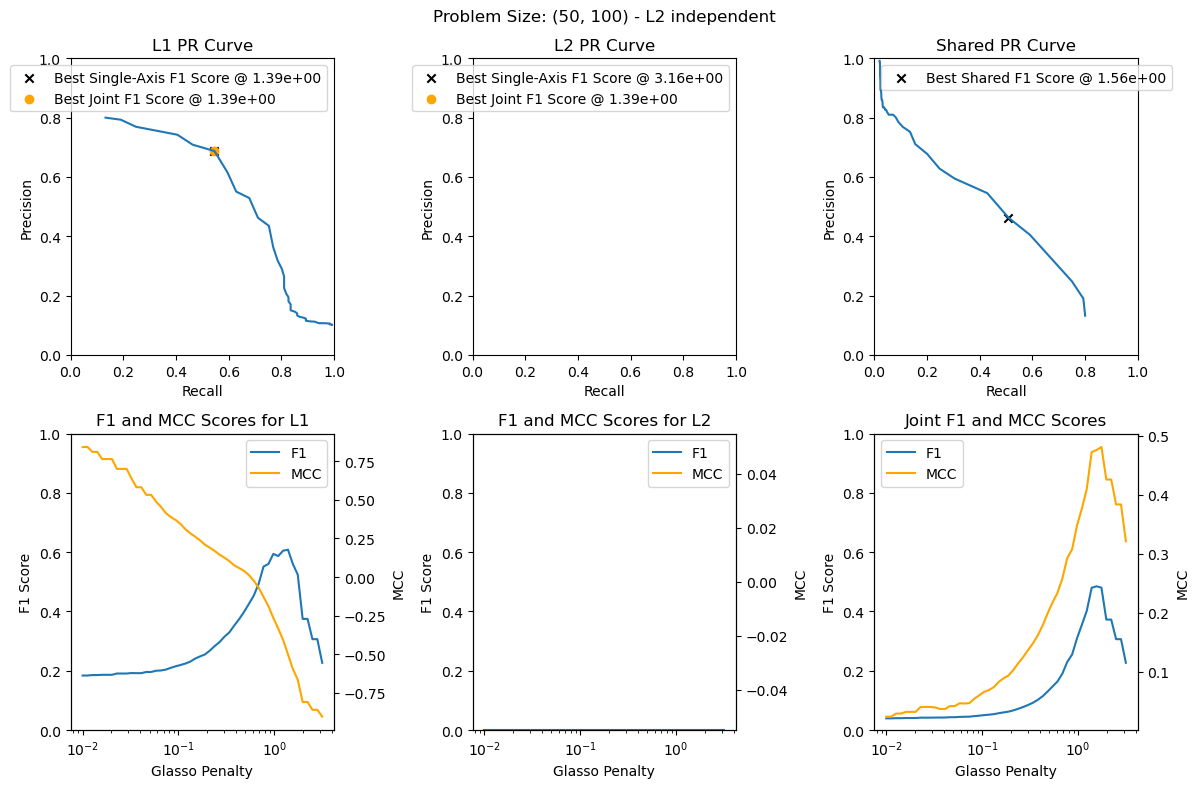

In [463]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (50, 100)

L1_star = np.tril(np.random.randn(n[0], n[0]))
L2_star = 0*np.eye(n[1])#np.tril(np.random.randn(n[1], n[1]))
# generate bernoulli sparsity pattern
L1_star[np.random.rand(*L1_star.shape) > 0.1] = 0
L2_star[np.random.rand(*L2_star.shape) > 0.1] = 0
L1_pattern = (np.abs(np.tril(L1_star, k=-1)) > 1e-16)
L2_pattern = (np.abs(np.tril(L2_star, k=-1)) > 1e-16)
np.fill_diagonal(L1_star, 2)
#np.fill_diagonal(L2_star, 2)
X = linalg.solve_sylvester(L1_star, L2_star, np.random.normal(size=n))
X /= np.linalg.norm(X, ord=2)
print("Data generated")

L1_init = np.tril(np.random.randn(n[0], n[0]))
np.fill_diagonal(L1_init, np.abs(np.diag(L1_init)) + 1.0)
L2_init = np.tril(np.random.randn(n[1], n[1]))
np.fill_diagonal(L2_init, np.abs(np.diag(L2_init)) + 1.0)
L_init = [L1_init, L2_init]
#glassoregs = np.logspace(1, -2, 50) # (50, 50)
#glassoregs = np.logspace(1, -1, 50) # (75, 75)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 100)
glassoregs = np.logspace(0.5, -2, 50) # (100, 50)
Lss, diags = warm_start(X, L_init, glassoregs=glassoregs)
print("Model fit")

L1_pattern_estim = [(np.abs(Ls[0]) > 1e-16) for Ls in Lss]
L2_pattern_estim = [(np.abs(Ls[1]) > 1e-16) for Ls in Lss]

# Remove diagonals
np.fill_diagonal(L1_pattern, 0)
np.fill_diagonal(L2_pattern, 0)
for i in range(len(Lss)):
    np.fill_diagonal(L1_pattern_estim[i], 0)
    np.fill_diagonal(L2_pattern_estim[i], 0)

L1_precision = [
    ((L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern_estim[i]).sum())
    if (L1_pattern_estim[i]).sum() != 0
    else 1
    for i in range(len(Lss))
]
L2_precision = [
    (L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern_estim[i]).sum()
    if (L2_pattern_estim[i]).sum() != 0
    else 1
    for i in range(len(Lss))
]
L1_precision = [p if not np.isinf(p) else 1 for p in L1_precision]
L2_precision = [p if not np.isinf(p) else 1 for p in L2_precision]
L1_recall = [(L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern).sum() for i in range(len(Lss))]
L2_recall = [(L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern).sum() for i in range(len(Lss))]

# Compute F1 and MCC
L1_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(L1_precision, L1_recall)]
L2_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(L2_precision, L2_recall)]
L1_TP = [np.tril(L1_pattern & L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_FP = [np.tril(L1_pattern & ~L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_TN = [np.tril(~L1_pattern & L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_FN = [np.tril(~L1_pattern & ~L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(L1_TP, L1_TN, L1_FP, L1_FN)
]
L2_TP = [np.tril(L2_pattern & L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_FP = [np.tril(L2_pattern & ~L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_TN = [np.tril(~L2_pattern & L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_FN = [np.tril(~L2_pattern & ~L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(L2_TP, L2_TN, L2_FP, L2_FN)
]

shared_TP = [
    np.tril(L1_pattern & L1_pattern_estim[i], k=-1).sum()
    + np.tril(L2_pattern & L2_pattern_estim[i], k=-1).sum()
    for i in range(len(Lss))
]
shared_FP = [
    np.tril(L1_pattern & ~L1_pattern_estim[i], k=-1).sum()
    + np.tril(L2_pattern & ~L2_pattern_estim[i], k=-1).sum()
    for i in range(len(Lss))
]
shared_TN = [
    np.tril(~L1_pattern & ~L1_pattern_estim[i], k=-1).sum()
    + np.tril(~L2_pattern & ~L2_pattern_estim[i], k=-1).sum()
    for i in range(len(Lss))
]
shared_FN = [
    np.tril(~L1_pattern & L1_pattern_estim[i], k=-1).sum()
    + np.tril(~L2_pattern & L2_pattern_estim[i], k=-1).sum()
    for i in range(len(Lss))
]

shared_prec = [TP / (TP + FP) for TP, FP in zip(shared_TP, shared_FP)]
shared_rec = [TP / (TP + FN) for TP, FN in zip(shared_TP, shared_FN)]
shared_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(shared_prec, shared_rec)]
shared_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(shared_TP, shared_TN, shared_FP, shared_FN)
]

L1_maxF1 = np.argmax(L1_F1)
L2_maxF1 = np.argmax(L2_F1)
Ls_maxF1 = np.argmax(np.array(L1_F1) + np.array(L2_F1))
sh_maxF1 = np.argmax(shared_F1)

fig, ((ax1, ax2, ax_s1), (ax3, ax4, ax_s2)) = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
ax1.plot(L1_recall, L1_precision)
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title("L1 PR Curve")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.scatter(L1_recall[L1_maxF1], L1_precision[L1_maxF1], marker='x', color='black', label=f"Best Single-Axis F1 Score @ {glassoregs[L1_maxF1]:.2e}")
ax1.scatter(L1_recall[Ls_maxF1], L1_precision[Ls_maxF1], marker='o', color='orange', label=f"Best Joint F1 Score @ {glassoregs[Ls_maxF1]:.2e}")
ax1.legend()
ax2.plot(L2_recall, L2_precision)
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("L2 PR Curve")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.scatter(L2_recall[L2_maxF1], L2_precision[L2_maxF1], marker='x', color='black', label=f"Best Single-Axis F1 Score @ {glassoregs[L2_maxF1]:.2e}")
ax2.scatter(L2_recall[Ls_maxF1], L2_precision[Ls_maxF1], marker='o', color='orange', label=f"Best Joint F1 Score @ {glassoregs[Ls_maxF1]:.2e}")
ax2.legend()
f1, = ax3.plot(glassoregs, L1_F1, label="F1")
ax3.set_xlabel("Glasso Penalty")
ax3.set_ylabel("F1 Score")
ax3.set_title("F1 and MCC Scores for L1")
ax3.set_ylim(0, 1)
ax3.set_xscale('log')
tax3 = ax3.twinx()
mcc, = tax3.plot(glassoregs, L1_MCC, label="MCC", color="orange")
tax3.set_ylabel("MCC")
tax3.legend([f1,mcc], [f1.get_label(), mcc.get_label()])
f1, = ax4.plot(glassoregs, L2_F1, label="F1")
ax4.set_xlabel("Glasso Penalty")
ax4.set_ylabel("F1 Score")
ax4.set_title("F1 and MCC Scores for L2")
ax4.set_ylim(0, 1)
ax4.set_xscale('log')
tax4 = ax4.twinx()
mcc, = tax4.plot(glassoregs, L2_MCC, label="MCC", color="orange")
tax4.set_ylabel("MCC")
tax4.legend([f1,mcc], [f1.get_label(), mcc.get_label()])

# Shared
ax_s1.plot(shared_rec, shared_prec)
ax_s1.set_xlabel("Recall")
ax_s1.set_ylabel("Precision")
ax_s1.set_title("Shared PR Curve")
ax_s1.set_xlim(0, 1)
ax_s1.set_ylim(0, 1)
ax_s1.scatter(
    shared_rec[sh_maxF1],
    shared_prec[sh_maxF1],
    marker='x',
    color='black',
    label=f"Best Shared F1 Score @ {glassoregs[sh_maxF1]:.2e}"
)
ax_s1.legend()

f1, = ax_s2.plot(glassoregs, shared_F1, label="F1")
ax_s2.set_xlabel("Glasso Penalty")
ax_s2.set_ylabel("F1 Score")
ax_s2.set_title("Joint F1 and MCC Scores")
ax_s2.set_ylim(0, 1)
ax_s2.set_xscale('log')
tax_s2 = ax_s2.twinx()
mcc, = tax_s2.plot(glassoregs, shared_MCC, label="MCC", color="orange")
tax_s2.set_ylabel("MCC")
tax_s2.legend([f1,mcc], [f1.get_label(), mcc.get_label()])


fig.suptitle(f"Problem Size: {n} - L2 independent")
fig.tight_layout()

Data generated
L1 Param: 3.1622776601683795


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/3950260077.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 2.8117686979742307
L1 Param: 2.50011038261793
L1 Param: 2.2229964825261948
L1 Param: 1.9765980717016338
L1 Param: 1.7575106248547918
L1 Param: 1.5627069765469952
L1 Param: 1.3894954943731377
L1 Param: 1.235482888256747
L1 Param: 1.0985411419875581
L1 Param: 0.976778110089489
L1 Param: 0.8685113737513525
L1 Param: 0.7722449945836258
L1 Param: 0.6866488450043002
L1 Param: 0.6105402296585328
L1 Param: 0.5428675439323859
L1 Param: 0.4826957437677871
L1 Param: 0.42919342601287785
L1 Param: 0.3816213407949356
L1 Param: 0.3393221771895328
L1 Param: 0.3017114810529294
L1 Param: 0.2682695795279726
L1 Param: 0.23853440064314188
L1 Param: 0.21209508879201905
L1 Param: 0.18858632787726495
L1 Param: 0.16768329368110083
L1 Param: 0.14909716571840645
L1 Param: 0.13257113655901087
L1 Param: 0.11787686347935872
L1 Param: 0.10481131341546858
L1 Param: 0.09319395762340775
L1 Param: 0.08286427728546843
L1 Param: 0.0736795455966163
L1 Param: 0.0655128556859551
L1 Param: 0.05825136712468927
L1 Par

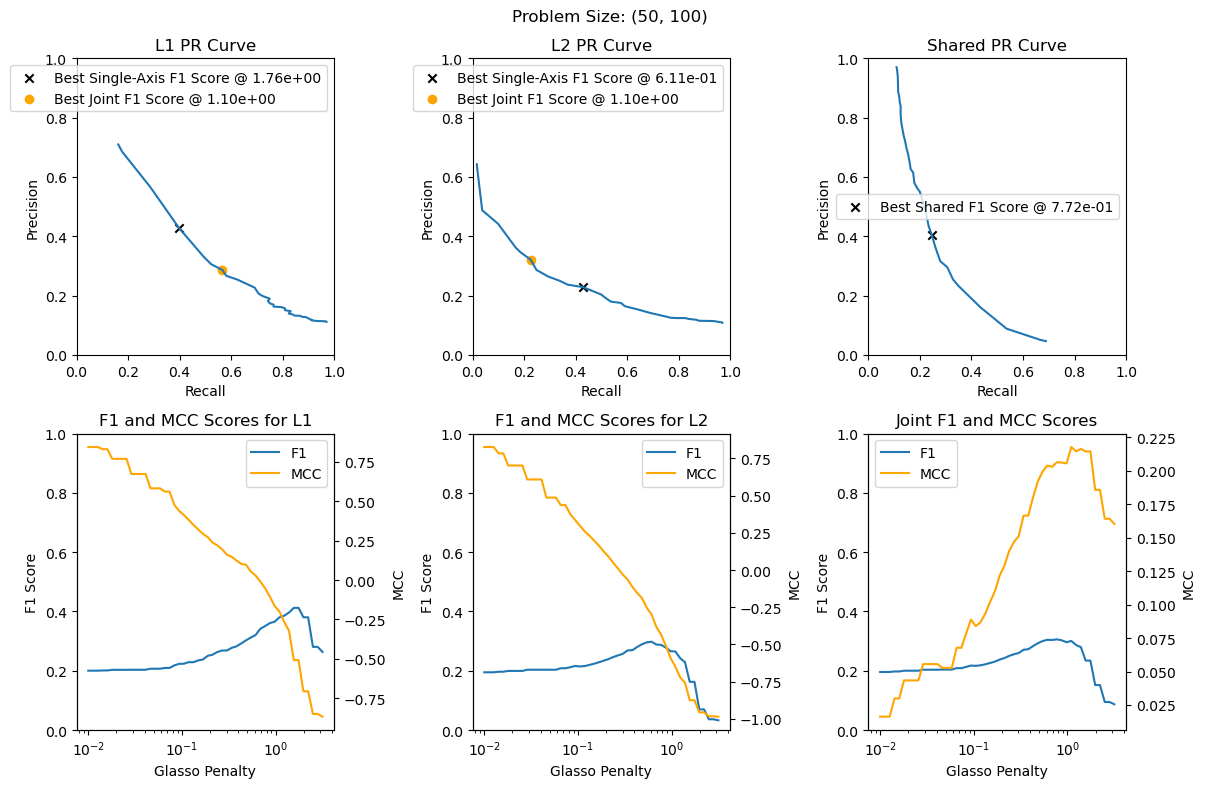

In [464]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (50, 100)

L1_star = np.tril(np.random.randn(n[0], n[0]))
L2_star = np.tril(np.random.randn(n[1], n[1]))
# generate bernoulli sparsity pattern
L1_star[np.random.rand(*L1_star.shape) > 0.1] = 0
L2_star[np.random.rand(*L2_star.shape) > 0.1] = 0
L1_pattern = (np.abs(np.tril(L1_star, k=-1)) > 1e-16)
L2_pattern = (np.abs(np.tril(L2_star, k=-1)) > 1e-16)
np.fill_diagonal(L1_star, 2)
np.fill_diagonal(L2_star, 2)
X = linalg.solve_sylvester(L1_star, L2_star, np.random.normal(size=n))
X /= np.linalg.norm(X, ord=2)
print("Data generated")

L1_init = np.tril(np.random.randn(n[0], n[0]))
np.fill_diagonal(L1_init, np.abs(np.diag(L1_init)) + 1.0)
L2_init = np.tril(np.random.randn(n[1], n[1]))
np.fill_diagonal(L2_init, np.abs(np.diag(L2_init)) + 1.0)
L_init = [L1_init, L2_init]
#glassoregs = np.logspace(1, -2, 50) # (50, 50)
#glassoregs = np.logspace(1, -1, 50) # (75, 75)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 100)
glassoregs = np.logspace(0.5, -2, 50) # (100, 50)
Lss, diags = warm_start(X, L_init, glassoregs=glassoregs)
print("Model fit")

L1_pattern_estim = [(np.abs(Ls[0]) > 1e-16) for Ls in Lss]
L2_pattern_estim = [(np.abs(Ls[1]) > 1e-16) for Ls in Lss]

# Remove diagonals
np.fill_diagonal(L1_pattern, 0)
np.fill_diagonal(L2_pattern, 0)
for i in range(len(Lss)):
    np.fill_diagonal(L1_pattern_estim[i], 0)
    np.fill_diagonal(L2_pattern_estim[i], 0)

L1_precision = [
    ((L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern_estim[i]).sum())
    if (L1_pattern_estim[i]).sum() != 0
    else 1
    for i in range(len(Lss))
]
L2_precision = [
    (L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern_estim[i]).sum()
    if (L2_pattern_estim[i]).sum() != 0
    else 1
    for i in range(len(Lss))
]
L1_precision = [p if not np.isinf(p) else 1 for p in L1_precision]
L2_precision = [p if not np.isinf(p) else 1 for p in L2_precision]
L1_recall = [(L1_pattern & L1_pattern_estim[i]).sum() / (L1_pattern).sum() for i in range(len(Lss))]
L2_recall = [(L2_pattern & L2_pattern_estim[i]).sum() / (L2_pattern).sum() for i in range(len(Lss))]

# Compute F1 and MCC
L1_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(L1_precision, L1_recall)]
L2_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(L2_precision, L2_recall)]
L1_TP = [np.tril(L1_pattern & L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_FP = [np.tril(L1_pattern & ~L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_TN = [np.tril(~L1_pattern & L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_FN = [np.tril(~L1_pattern & ~L1_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L1_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(L1_TP, L1_TN, L1_FP, L1_FN)
]
L2_TP = [np.tril(L2_pattern & L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_FP = [np.tril(L2_pattern & ~L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_TN = [np.tril(~L2_pattern & L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_FN = [np.tril(~L2_pattern & ~L2_pattern_estim[i], k=-1).sum() for i in range(len(Lss))]
L2_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(L2_TP, L2_TN, L2_FP, L2_FN)
]

shared_TP = [
    np.tril(L1_pattern & L1_pattern_estim[i], k=-1).sum()
    + np.tril(L2_pattern & L2_pattern_estim[i], k=-1).sum()
    for i in range(len(Lss))
]
shared_FP = [
    np.tril(L1_pattern & ~L1_pattern_estim[i], k=-1).sum()
    + np.tril(L2_pattern & ~L2_pattern_estim[i], k=-1).sum()
    for i in range(len(Lss))
]
shared_TN = [
    np.tril(~L1_pattern & ~L1_pattern_estim[i], k=-1).sum()
    + np.tril(~L2_pattern & ~L2_pattern_estim[i], k=-1).sum()
    for i in range(len(Lss))
]
shared_FN = [
    np.tril(~L1_pattern & L1_pattern_estim[i], k=-1).sum()
    + np.tril(~L2_pattern & L2_pattern_estim[i], k=-1).sum()
    for i in range(len(Lss))
]

shared_prec = [TP / (TP + FP) for TP, FP in zip(shared_TP, shared_FP)]
shared_rec = [TP / (TP + FN) for TP, FN in zip(shared_TP, shared_FN)]
shared_F1 = [x if not np.isnan(x := 2*prec*rec/(prec+rec)) else 0 for prec, rec in zip(shared_prec, shared_rec)]
shared_MCC = [
    (TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    for TP, TN, FP, FN in zip(shared_TP, shared_TN, shared_FP, shared_FN)
]

L1_maxF1 = np.argmax(L1_F1)
L2_maxF1 = np.argmax(L2_F1)
Ls_maxF1 = np.argmax(np.array(L1_F1) + np.array(L2_F1))
sh_maxF1 = np.argmax(shared_F1)

fig, ((ax1, ax2, ax_s1), (ax3, ax4, ax_s2)) = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
ax1.plot(L1_recall, L1_precision)
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title("L1 PR Curve")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.scatter(L1_recall[L1_maxF1], L1_precision[L1_maxF1], marker='x', color='black', label=f"Best Single-Axis F1 Score @ {glassoregs[L1_maxF1]:.2e}")
ax1.scatter(L1_recall[Ls_maxF1], L1_precision[Ls_maxF1], marker='o', color='orange', label=f"Best Joint F1 Score @ {glassoregs[Ls_maxF1]:.2e}")
ax1.legend()
ax2.plot(L2_recall, L2_precision)
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("L2 PR Curve")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.scatter(L2_recall[L2_maxF1], L2_precision[L2_maxF1], marker='x', color='black', label=f"Best Single-Axis F1 Score @ {glassoregs[L2_maxF1]:.2e}")
ax2.scatter(L2_recall[Ls_maxF1], L2_precision[Ls_maxF1], marker='o', color='orange', label=f"Best Joint F1 Score @ {glassoregs[Ls_maxF1]:.2e}")
ax2.legend()
f1, = ax3.plot(glassoregs, L1_F1, label="F1")
ax3.set_xlabel("Glasso Penalty")
ax3.set_ylabel("F1 Score")
ax3.set_title("F1 and MCC Scores for L1")
ax3.set_ylim(0, 1)
ax3.set_xscale('log')
tax3 = ax3.twinx()
mcc, = tax3.plot(glassoregs, L1_MCC, label="MCC", color="orange")
tax3.set_ylabel("MCC")
tax3.legend([f1,mcc], [f1.get_label(), mcc.get_label()])
f1, = ax4.plot(glassoregs, L2_F1, label="F1")
ax4.set_xlabel("Glasso Penalty")
ax4.set_ylabel("F1 Score")
ax4.set_title("F1 and MCC Scores for L2")
ax4.set_ylim(0, 1)
ax4.set_xscale('log')
tax4 = ax4.twinx()
mcc, = tax4.plot(glassoregs, L2_MCC, label="MCC", color="orange")
tax4.set_ylabel("MCC")
tax4.legend([f1,mcc], [f1.get_label(), mcc.get_label()])

# Shared
ax_s1.plot(shared_rec, shared_prec)
ax_s1.set_xlabel("Recall")
ax_s1.set_ylabel("Precision")
ax_s1.set_title("Shared PR Curve")
ax_s1.set_xlim(0, 1)
ax_s1.set_ylim(0, 1)
ax_s1.scatter(
    shared_rec[sh_maxF1],
    shared_prec[sh_maxF1],
    marker='x',
    color='black',
    label=f"Best Shared F1 Score @ {glassoregs[sh_maxF1]:.2e}"
)
ax_s1.legend()

f1, = ax_s2.plot(glassoregs, shared_F1, label="F1")
ax_s2.set_xlabel("Glasso Penalty")
ax_s2.set_ylabel("F1 Score")
ax_s2.set_title("Joint F1 and MCC Scores")
ax_s2.set_ylim(0, 1)
ax_s2.set_xscale('log')
tax_s2 = ax_s2.twinx()
mcc, = tax_s2.plot(glassoregs, shared_MCC, label="MCC", color="orange")
tax_s2.set_ylabel("MCC")
tax_s2.legend([f1,mcc], [f1.get_label(), mcc.get_label()])


fig.suptitle(f"Problem Size: {n}")
fig.tight_layout()

Data generated


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/3950260077.py:222: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(np.array(objs) - min(objs)))
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/3950260077.py:226: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(-np.array(eps)))
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/3950260077.py:226: RuntimeWarning: invalid value encountered in log10
  ax2.plot(np.log10(-np.array(eps)))


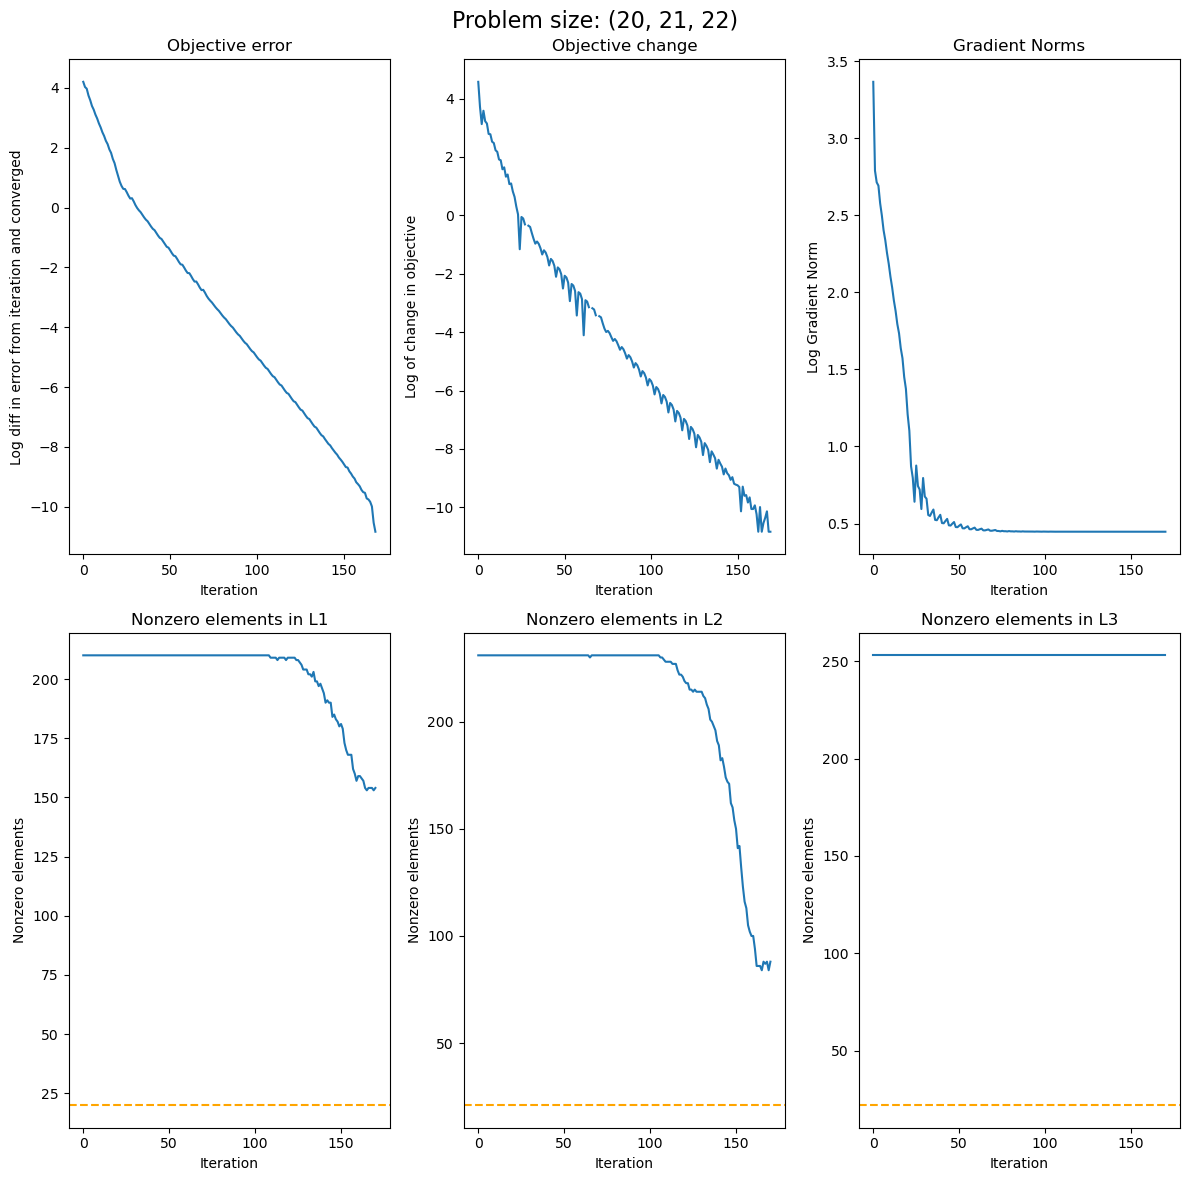

In [458]:
def proximal_backtracking_line_search(
    f: ObjectiveOracle,
    prox: ProximalOracle,
    P: ProjectionOracle,
    del_f: Direction,
    Ls: list[FactorMatrix],
    init_alpha: StepSize,
    tau: float,
    beta: float
) -> list[FactorMatrix]:
    """
    Backtracking line search
    """
    alpha = init_alpha
    
    cur_f = f(Ls)
    while True:
        new_Ls = prox(P([L - alpha * d for L, d in zip(Ls, del_f)]))
        new_f = f(new_Ls)
        prox_direc = [(L - Lnew) for L, Lnew in zip(Ls, new_Ls)]
        grad_norm = sum([np.linalg.norm(d)**2 for d in prox_direc])
        if new_f <= cur_f - beta * grad_norm / alpha:
            break
        alpha *= tau
        if alpha < 1e-30:
            warnings.warn("Alpha too small, stopping line search")
            return Ls

    return new_Ls

def proximal_accelerated_gradient(
    f: ObjectiveOracle,
    del_f: GradientOracle,
    prox: ProximalOracle,
    P: ProjectionOracle,
    Ls: list[FactorMatrix],
    mu: Momentum,
    init_alpha: StepSize,
    tau: float,
    beta: float,
    max_iter: int = 1000,
    tol: float = 1e-5,
) -> tuple[list[FactorMatrix], Diagnostics]:
    """
    Gradient descent algorithm
    """

    cur_f = f(Ls)

    objs = []
    eps = []
    grads = []
    nonzeros = [[] for _ in Ls]
    
    for i in range(max_iter):
        grad = del_f(Ls)
        if i > 0:
            accelerated_Ls = P([L + mu * (L - old_L) for L, old_L in zip(Ls, oldest_Ls)])
        else:
            accelerated_Ls = Ls
        oldest_Ls = Ls
        Ls = proximal_backtracking_line_search(f, prox, P, grad, accelerated_Ls, init_alpha, tau, beta)

        new_f = f(Ls)
        delta = new_f - cur_f
        objs.append(new_f)
        eps.append(delta)
        grads.append(sum([np.linalg.norm(g) for g in grad]))

        for i, L in enumerate(Ls):
            nonzeros[i].append(np.count_nonzero(L))
        
        if np.abs(delta) < tol:
            break
        cur_f = new_f

    return Ls, (objs, eps, grads, nonzeros)


def get_optimizer_oracles(
    X: InputData,
    frobreg: float = 0,
    glassoregs: Optional[tuple[float, ...] | float] = None
) -> tuple[ObjectiveOracle, GradientOracle, ProximalOracle]:
    """
    Creates oracles from our input data
    """
    if glassoregs is None:
        glassoregs = [0 for _ in range(X.ndims)]
    if isinstance(glassoregs, float):
        glassoregs = [glassoregs for _ in range(X.ndim)]

    objective: ObjectiveOracle
    def objective(Ls: list[FactorMatrix], decomp=False) -> float:
        if (len(Ls) <= 1):
            raise NotImplementedError("Must be at least matrix-variate!")

        trace_term = 0
        for i, L in enumerate(Ls):
            trace_term += np.einsum("ij,j...->i...", L, X.swapaxes(0, i)).swapaxes(0, i)
        trace_term = (trace_term**2).sum()

        log_term = np.diag(Ls[0])
        for L in Ls[1:]:
            log_term = np.add.outer(log_term, np.diag(L))
        log_term = -2 * np.log(log_term).sum()

        frob_term = 0
        for L in Ls:
            frob_term += (L**2).sum()
        frob_term *= frobreg
        
        differentiable_term = trace_term + log_term + frob_term

        if (np.isnan(differentiable_term)):
            raise ValueError("NaN in differentiable term")
        

        nondifferentiable_term = sum([glassoregs[i] * np.abs(np.tril(L)).sum() for i, L in enumerate(Ls)])
        if decomp:
            return differentiable_term, nondifferentiable_term
        return differentiable_term + nondifferentiable_term
    
    gradient: GradientOracle
    def gradient(Ls: list[FactorMatrix]) -> Direction:
        if (len(Ls) <= 1):
            raise NotImplementedError("Must be at least matrix-variate!")
        
        grads = [None] * len(Ls)

        full_log_term = np.diag(Ls[0])
        for L in Ls[1:]:
            full_log_term = np.add.outer(full_log_term, np.diag(L))
        full_log_term = (-2 / full_log_term)

        for i, L in enumerate(Ls):
            X_i = np.swapaxes(X, i, 0).reshape(L.shape[0], -1)
            trace_term = L @ X_i @ X_i.T
            for j, other_L in enumerate(Ls):
                if i == j:
                    continue
                X_ij = np.moveaxis(X, [i, j], [0, 1]).reshape(L.shape[0], other_L.shape[0], -1)
                trace_term += np.einsum("ijc,kj,lkc->il", X_ij, other_L, X_ij)
            trace_term = np.tril(2 * trace_term)

            log_term = np.diag(full_log_term.swapaxes(i, 0).reshape(L.shape[0], -1).sum(axis=1))

            frob_term = 2*frobreg*L

            grads[i] = trace_term + log_term + frob_term

        return grads
    
    proximal: ProximalOracle
    def proximal(Ls: list[FactorMatrix]) -> list[FactorMatrix]:
        """
        Soft thresholding on each of the Ls, not affecting their diagonals
        """
        new_Ls = []
        for i, L in enumerate(Ls):
            L_diag = np.diag(L)
            new_L = np.sign(L) * np.maximum(np.abs(L) - glassoregs[i], 0)
            np.fill_diagonal(new_L, L_diag)
            new_Ls.append(new_L)
        return new_Ls
    
    return objective, gradient, proximal

project_to_lower_with_positive_diag: Projection
def project_to_lower_with_positive_diag(Ms: list[FactorMatrix], tol=1e-6) -> list[FactorMatrix]:
    """
    Project M to strictly lower-triangular + positive diagonal
    """

    Ls = []
    for M in Ms:
        L = np.tril(M)
        np.fill_diagonal(L, np.maximum(np.diag(L), tol))  # Ensure positive diag
        Ls.append(L)
    return Ls

np.random.seed(1)
n = (20, 21, 22)

L1_star = np.tril(np.random.randn(n[0], n[0]))
L2_star = np.tril(np.random.randn(n[1], n[1]))
X = np.concatenate([
    linalg.solve_sylvester(L1_star, L2_star, np.random.normal(size=n[0:2]))[..., np.newaxis]
    for i in range(n[2])
], axis=2)
X /= np.sqrt((X**2).sum())
print("Data generated")

L1_init = np.tril(np.random.randn(n[0], n[0]))
np.fill_diagonal(L1_init, np.abs(np.diag(L1_init)) + 1.0)
L2_init = np.tril(np.random.randn(n[1], n[1]))
np.fill_diagonal(L2_init, np.abs(np.diag(L2_init)) + 1.0)
L3_init = np.tril(np.random.randn(n[2], n[2]))
np.fill_diagonal(L3_init, np.abs(np.diag(L3_init)) + 1.0)
L_init = [L1_init, L2_init, L3_init]

frobreg = 1/np.prod(n)**(1/len(n))
glassoreg = 0.5e-6
objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

Ls, (objs, eps, grads, nonzeros) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=5000,
    tol=1e-20
)

# Plot convergence
fig, ((ax1, ax2, ax3), nzax) = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
ax1.plot(np.log10(np.array(objs) - min(objs)))
ax1.set_title("Objective error")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Log diff in error from iteration and converged")
ax2.plot(np.log10(-np.array(eps)))
ax2.set_title("Objective change")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Log of change in objective")
ax3.plot(np.log10(np.array(grads)))
ax3.set_title("Gradient Norms")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Log Gradient Norm")

for i, ax in enumerate(nzax):
    if i >= len(X.shape):
        continue
    ax.plot(nonzeros[i])
    ax.set_title(f"Nonzero elements in L{i+1}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Nonzero elements")
    ax.axhline(y=n[i], color='orange', linestyle='--')

fig.suptitle(f"Problem size: {n}", fontsize=16)
fig.tight_layout()

In [533]:
np.random.seed(1)

def generate_Ls(dims: tuple[int, ...], sparsity: float) -> tuple[list[FactorMatrix], list[FactorMatrix]]:
    Ls = []
    L_patterns = []

    for d in dims:
        L_star = np.tril(np.random.randn(d, d))

        # generate bernoulli sparsity pattern
        L_star[np.random.rand(*L_star.shape) > sparsity] = 0
        L_pattern = (np.abs(np.tril(L_star, k=-1)) > 1e-16)
        np.fill_diagonal(L_star, 2)
        np.fill_diagonal(L_pattern, 0)

        Ls.append(L_star)
        L_patterns.append(L_pattern)

    return Ls, L_patterns

def generate_sylvester_data(Ls: list[FactorMatrix], normalize: bool=False) -> InputData:
    """
    Generates data that follows the tensor-variate sylvester equation
    """
    n = [L.shape[0] for L in Ls]
    dim = len(n)

    if dim == 2:
        # Matrix variate equation sub-case; already a SciPy routine to do this!
        # Note that the routine has some preprocessing steps to triangularize our
        # matrices, which is not needed here, so to squeeze out extra efficiency
        # one could drop down to the lapack dtrsyl routine.
        X = linalg.solve_sylvester(Ls[0], Ls[1], np.random.normal(size=n))
    else:
        # There is literature on solving this, but in general the problem is
        # more difficult and there do not exist SciPy routines.
        # So, we'll take the 'lazy way' and reduce it to the dim=2 case.
        # Note that this has egregious space requirements.  In general,
        # if all K axes have size d, then this algorithm transforms the
        # data into two d^(K // 2) x d^(K // 2) matrices.
        # That's a bit expensive...
        #
        # Essentially, we can handle small tensors up to dim=4, after which
        # all bets are off!
        left_Ls = Ls[:(dim // 2)]
        right_Ls = Ls[(dim // 2):]

        left_L = left_Ls[0]
        for L in left_Ls[1:]:
            left_L = np.kron(left_L, np.eye(L.shape[0])) + np.kron(np.eye(left_L.shape[0]), L)
        right_L = right_Ls[0]
        for L in right_Ls[1:]:
            right_L = np.kron(right_L, np.eye(L.shape[0])) + np.kron(np.eye(right_L.shape[0]), L)
        
        X = linalg.solve_sylvester(
            left_L,
            right_L,
            np.random.normal(size=(left_L.shape[0], right_L.shape[0]))
        ).reshape(n)

    if normalize:
        X /= np.sqrt((X**2).sum())
    return X

n = (20, 21, 22, 23)
Ls, _ = generate_Ls((20, 21, 22, 23), 0.1)
generate_sylvester_data(Ls, normalize=True).shape

(20, 21, 22, 23)

Data generated
L1 Param: 10.0
L1 Param: 9.102981779915218
L1 Param: 8.286427728546844
L1 Param: 7.543120063354617
L1 Param: 6.8664884500430015
L1 Param: 6.250551925273973
L1 Param: 5.689866029018296
L1 Param: 5.179474679231212
L1 Param: 4.714866363457395
L1 Param: 4.291934260128778
L1 Param: 3.906939937054617
L1 Param: 3.5564803062231296
L1 Param: 3.237457542817644
L1 Param: 2.947051702551811
L1 Param: 2.682695795279726
L1 Param: 2.4420530945486516
L1 Param: 2.222996482526195
L1 Param: 2.023589647725157
L1 Param: 1.8420699693267164
L1 Param: 1.6768329368110082
L1 Param: 1.5264179671752338
L1 Param: 1.3894954943731377
L1 Param: 1.2648552168552964
L1 Param: 1.1513953993264474


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/3950260077.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 1.0481131341546859
L1 Param: 0.9540954763499939
L1 Param: 0.8685113737513529
L1 Param: 0.7906043210907702
L1 Param: 0.7196856730011522
L1 Param: 0.655128556859551
L1 Param: 0.5963623316594646
L1 Param: 0.5428675439323862
L1 Param: 0.49417133613238357
L1 Param: 0.44984326689694465
L1 Param: 0.40949150623804254
L1 Param: 0.3727593720314942
L1 Param: 0.33932217718953295
L1 Param: 0.3088843596477482
L1 Param: 0.28117686979742307
L1 Param: 0.2559547922699537
L1 Param: 0.2329951810515373
L1 Param: 0.21209508879201916
L1 Param: 0.19306977288832505
L1 Param: 0.1757510624854792
L1 Param: 0.1599858719606059
L1 Param: 0.14563484775012445
L1 Param: 0.13257113655901095
L1 Param: 0.1206792640639329
L1 Param: 0.10985411419875583
L1 Param: 0.1
Model fit


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/376182511.py:106: RuntimeWarning: invalid value encountered in divide
  precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(n))]
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/376182511.py:107: RuntimeWarning: invalid value encountered in divide
  shared_precs = shared_TPs / (shared_TPs + shared_FPs)
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/376182511.py:118: RuntimeWarning: invalid value encountered in divide
  (TPs[i]*TNs[i] - FPs[i]*FNs[i])
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/376182511.py:123: RuntimeWarning: invalid value encountered in divide
  (shared_TPs * shared_TNs - shared_FPs * shared_FNs)


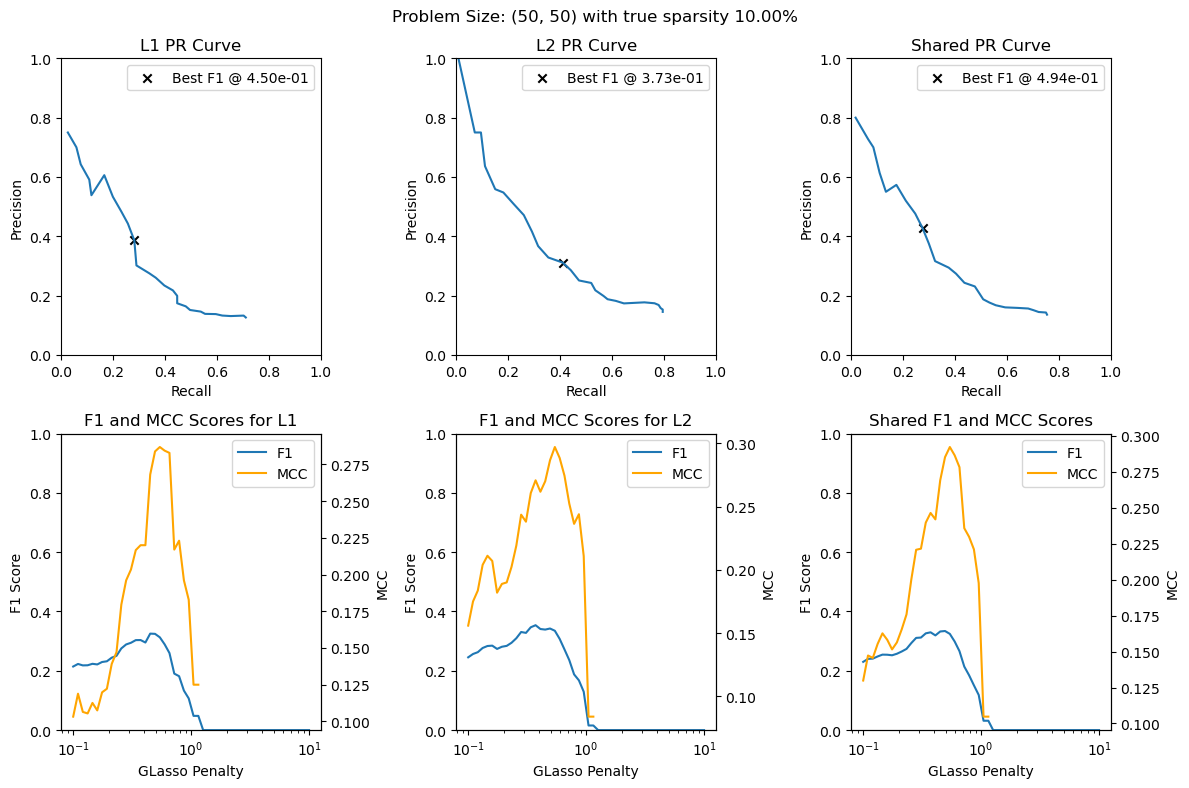

In [542]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (50, 50)
sparsity = 0.1

L_stars, L_patterns = generate_Ls(n, sparsity)
X = generate_sylvester_data(L_stars, normalize=True)
print("Data generated")

L_inits = []
for i in range(len(n)):
    L_init = np.tril(np.random.randn(n[i], n[i]))
    np.fill_diagonal(L_init, np.abs(np.diag(L_init)) + 1.0)
    L_inits.append(L_init)
#glassoregs = np.logspace(1, -2, 50) # (50, 50)
glassoregs = np.logspace(1, -1, 50) # (75, 75)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 100)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 50)
Lss, diags = warm_start(X, L_inits, glassoregs=glassoregs)
print("Model fit")


L_estim_patterns = []
for Ls in Lss:
    to_add = []
    for L in Ls:
        pattern = np.abs(L) > 1e-16
        np.fill_diagonal(pattern, 0)
        to_add.append(pattern)
    L_estim_patterns.append(to_add)

TPs = np.array([
    [
        np.tril(L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FPs = np.array([
    [
        np.tril(~L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
TNs = np.array([
    [
        np.tril(~L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FNs = np.array([
    [
        np.tril(L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T

shared_TPs = TPs.sum(axis=0)
shared_FPs = FPs.sum(axis=0)
shared_TNs = TNs.sum(axis=0)
shared_FNs = FNs.sum(axis=0)

precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(n))]
shared_precs = shared_TPs / (shared_TPs + shared_FPs)
recs = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(n))]
shared_recs = shared_TPs / (shared_TPs + shared_FNs)
f1s = [2*precs[i]*recs[i]/(precs[i]+recs[i]) for i in range(len(n))]
for i in range(len(f1s)):
    blah = f1s[i]
    blah[np.isnan(blah)] = 0
    f1s[i] = blah
shared_f1s =  2 * (shared_precs * shared_recs)/(shared_precs + shared_recs)
shared_f1s[np.isnan(shared_f1s)] = 0
mccs = [
    (TPs[i]*TNs[i] - FPs[i]*FNs[i])
    / np.sqrt((TPs[i]+FPs[i])*(TPs[i]+FNs[i])*(TNs[i]+FPs[i])*(TNs[i]+FNs[i]))
    for i in range(len(n))
]
shared_mcc = (
    (shared_TPs * shared_TNs - shared_FPs * shared_FNs)
    / np.sqrt(
        (shared_TPs + shared_FPs)
        * (shared_TPs + shared_FNs)
        * (shared_TNs + shared_FPs)
        * (shared_TNs + shared_FNs)
    )
)

Ls_maxF1 = [np.argmax(f1) for f1 in f1s]
sh_maxF1 = np.argmax(shared_f1s)

fig, (pr_axes, f1mcc_axes) = plt.subplots(ncols=len(n)+1, nrows=2, figsize=(12, 8))

for i, ax in enumerate(pr_axes):
    if i < len(pr_axes) - 1:
        precision = precs[i]
        recall = recs[i]
        best_greg_idx = Ls_maxF1[i]
        best_greg = glassoregs[best_greg_idx]
        ax.set_title(f"L{i+1} PR Curve")
    else:
        precision = shared_precs
        recall = shared_recs
        best_greg_idx = sh_maxF1
        best_greg = glassoregs[best_greg_idx]
        ax.set_title(f"Shared PR Curve")
    best_prec = precision[best_greg_idx]
    best_rec = recall[best_greg_idx]
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.scatter(best_rec, best_prec, marker='x', color='black', label=f"Best F1 @ {best_greg:.2e}")
    ax.legend()

for i, ax in enumerate(f1mcc_axes):
    if i < len(pr_axes) - 1:
        cur_f1 = f1s[i]
        cur_mcc = mccs[i]
        ax.set_title(f"F1 and MCC Scores for L{i+1}")
    else:
        cur_f1 = shared_f1s
        cur_mcc = shared_mcc
        ax.set_title("Shared F1 and MCC Scores")
    f1, = ax.plot(glassoregs, cur_f1, label="F1")
    ax.set_xlabel("GLasso Penalty")
    ax.set_ylabel("F1 Score")
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    tax = ax.twinx()
    mcc, = tax.plot(glassoregs, cur_mcc, label="MCC", color="orange")
    tax.set_ylabel("MCC")
    tax.legend([f1, mcc], [f1.get_label(), mcc.get_label()])

fig.suptitle(f"Problem Size: {n} with true sparsity {sparsity:.2%}")
fig.tight_layout()

Data generated
L1 Param: 3.1622776601683795
L1 Param: 2.8117686979742307
L1 Param: 2.50011038261793
L1 Param: 2.2229964825261948
L1 Param: 1.9765980717016338
L1 Param: 1.7575106248547918
L1 Param: 1.5627069765469952
L1 Param: 1.3894954943731377
L1 Param: 1.235482888256747


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/3950260077.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 1.0985411419875581
L1 Param: 0.976778110089489
L1 Param: 0.8685113737513525
L1 Param: 0.7722449945836258
L1 Param: 0.6866488450043002
L1 Param: 0.6105402296585328
L1 Param: 0.5428675439323859
L1 Param: 0.4826957437677871
L1 Param: 0.42919342601287785
L1 Param: 0.3816213407949356
L1 Param: 0.3393221771895328
L1 Param: 0.3017114810529294
L1 Param: 0.2682695795279726
L1 Param: 0.23853440064314188
L1 Param: 0.21209508879201905
L1 Param: 0.18858632787726495
L1 Param: 0.16768329368110083
L1 Param: 0.14909716571840645
L1 Param: 0.13257113655901087
L1 Param: 0.11787686347935872
L1 Param: 0.10481131341546858
L1 Param: 0.09319395762340775
L1 Param: 0.08286427728546843
L1 Param: 0.0736795455966163
L1 Param: 0.0655128556859551
L1 Param: 0.05825136712468927
L1 Param: 0.0517947467923121
L1 Param: 0.04605378255822414
L1 Param: 0.040949150623804255
L1 Param: 0.03641031949310673
L1 Param: 0.032374575428176434
L1 Param: 0.028786155923545685
L1 Param: 0.025595479226995357
L1 Param: 0.0227584592

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/4081534327.py:106: RuntimeWarning: invalid value encountered in divide
  precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(n))]
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/4081534327.py:107: RuntimeWarning: invalid value encountered in divide
  shared_precs = shared_TPs / (shared_TPs + shared_FPs)
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/4081534327.py:113: RuntimeWarning: invalid value encountered in divide
  (TPs[i]*TNs[i] - FPs[i]*FNs[i])
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/4081534327.py:124: RuntimeWarning: invalid value encountered in divide
  (shared_TPs * shared_TNs - shared_FPs * shared_FNs)


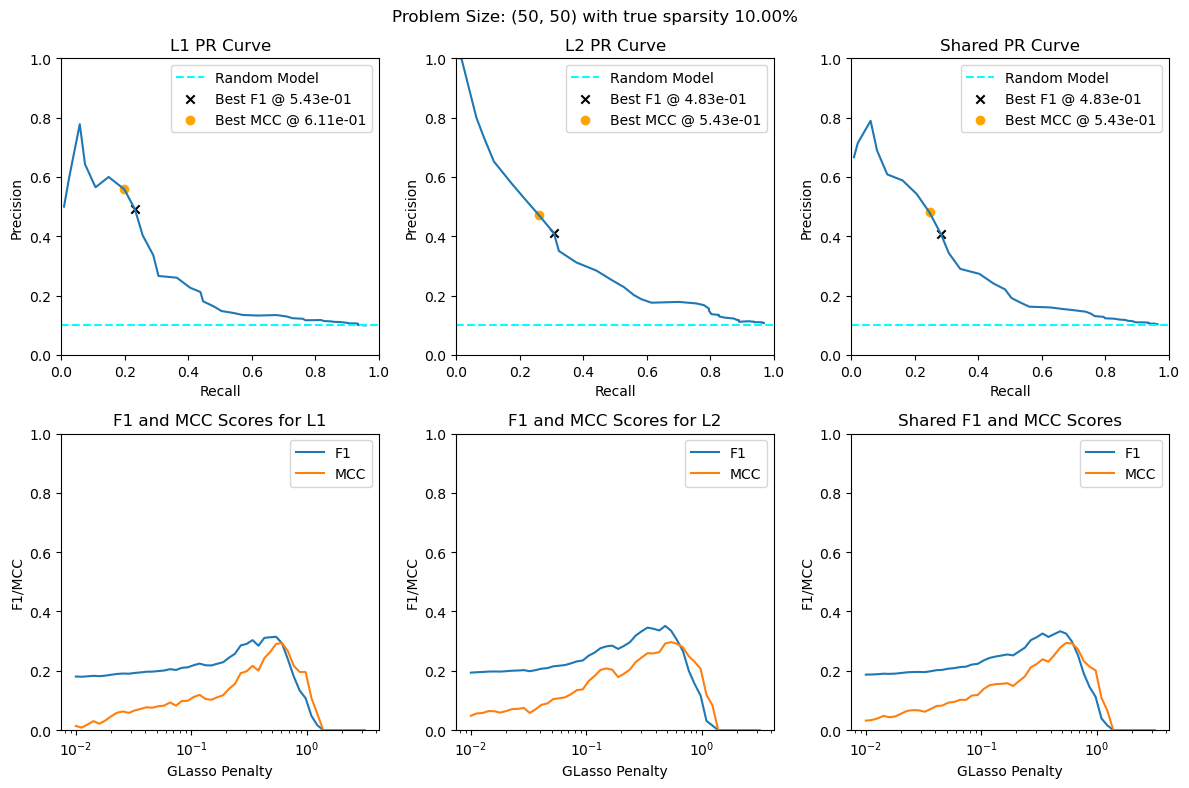

In [ ]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (50, 50)
sparsity = 0.1

L_stars, L_patterns = generate_Ls(n, sparsity)
X = generate_sylvester_data(L_stars, normalize=True)
print("Data generated")

L_inits = []
for i in range(len(n)):
    L_init = np.tril(np.random.randn(n[i], n[i]))
    np.fill_diagonal(L_init, np.abs(np.diag(L_init)) + 1.0)
    L_inits.append(L_init)
#glassoregs = np.logspace(1, -2, 50) # (50, 50)
#glassoregs = np.logspace(1, -1, 50) # (75, 75)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 100)
glassoregs = np.logspace(0.5, -2, 50) # (100, 50)
Lss, diags = warm_start(X, L_inits, glassoregs=glassoregs)
print("Model fit")


L_estim_patterns = []
for Ls in Lss:
    to_add = []
    for L in Ls:
        pattern = np.abs(L) > 1e-16
        np.fill_diagonal(pattern, 0)
        to_add.append(pattern)
    L_estim_patterns.append(to_add)

TPs = np.array([
    [
        np.tril(L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FPs = np.array([
    [
        np.tril(~L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
TNs = np.array([
    [
        np.tril(~L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FNs = np.array([
    [
        np.tril(L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T

shared_TPs = TPs.sum(axis=0)
shared_FPs = FPs.sum(axis=0)
shared_TNs = TNs.sum(axis=0)
shared_FNs = FNs.sum(axis=0)

precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(n))]
shared_precs = shared_TPs / (shared_TPs + shared_FPs)
recs = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(n))]
shared_recs = shared_TPs / (shared_TPs + shared_FNs)

f1s = [2*precs[i]*recs[i]/(precs[i]+recs[i]) for i in range(len(n))]
mccs = [
    (TPs[i]*TNs[i] - FPs[i]*FNs[i])
    / np.sqrt((TPs[i]+FPs[i])*(TPs[i]+FNs[i])*(TNs[i]+FPs[i])*(TNs[i]+FNs[i]))
    for i in range(len(n))
]
for i in range(len(f1s)):
    f1s[i][np.isnan(f1s[i])] = 0
    mccs[i][np.isnan(mccs[i])] = 0

shared_f1s =  2 * (shared_precs * shared_recs)/(shared_precs + shared_recs)
shared_f1s[np.isnan(shared_f1s)] = 0
shared_mccs = (
    (shared_TPs * shared_TNs - shared_FPs * shared_FNs)
    / np.sqrt(
        (shared_TPs + shared_FPs)
        * (shared_TPs + shared_FNs)
        * (shared_TNs + shared_FPs)
        * (shared_TNs + shared_FNs)
    )
)
shared_mccs[np.isnan(shared_mccs)] = 0

Ls_maxF1 = [np.argmax(f1) for f1 in f1s]
sh_maxF1 = np.argmax(shared_f1s)
Ls_maxMCC = [np.argmax(mcc) for mcc in mccs]
sh_maxMCC = np.argmax(shared_mccs)

fig, (pr_axes, f1mcc_axes) = plt.subplots(ncols=len(n)+1, nrows=2, figsize=(12, 8))

for i, ax in enumerate(pr_axes):
    if i < len(pr_axes) - 1:
        precision = precs[i]
        recall = recs[i]
        best_greg_f1_idx = Ls_maxF1[i]
        best_greg_mcc_idx = Ls_maxMCC[i]
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"L{i+1} PR Curve")
    else:
        precision = shared_precs
        recall = shared_recs
        best_greg_f1_idx = sh_maxF1
        best_greg_mcc_idx = sh_maxMCC
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"Shared PR Curve")
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axhline(sparsity, label="Random Model", linestyle='--', color='red')

    best_prec_f1 = precision[best_greg_f1_idx]
    best_rec_f1 = recall[best_greg_f1_idx]
    ax.scatter(best_rec_f1, best_prec_f1, marker='x', color='black', label=f"Best F1 @ {best_greg_f1:.2e}")

    best_prec_mcc = precision[best_greg_mcc_idx]
    best_rec_mcc = recall[best_greg_mcc_idx]
    ax.scatter(best_rec_mcc, best_prec_mcc, marker='o', color='orange', label=f"Best MCC @ {best_greg_mcc:.2e}")

    ax.legend()

for i, ax in enumerate(f1mcc_axes):
    if i < len(pr_axes) - 1:
        cur_f1 = f1s[i]
        cur_mcc = mccs[i]
        ax.set_title(f"F1 and MCC Scores for L{i+1}")
    else:
        cur_f1 = shared_f1s
        cur_mcc = shared_mccs
        ax.set_title("Shared F1 and MCC Scores")
    ax.plot(glassoregs, cur_f1, label="F1")
    ax.plot(glassoregs, cur_mcc, label="MCC")
    ax.set_xlabel("GLasso Penalty")
    ax.set_ylabel("F1/MCC")
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    #tax = ax.twinx()
    #mcc, = tax.plot(glassoregs, cur_mcc, label="MCC", color="orange")
    #tax.set_ylabel("MCC")
    ax.legend()#[f1, mcc], [f1.get_label(), mcc.get_label()])

fig.suptitle(f"Problem Size: {n} with true sparsity {sparsity:.2%}")
fig.tight_layout()

In [ ]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (100, 50)
sparsity = 0.1

L_stars, L_patterns = generate_Ls(n, sparsity)
X = generate_sylvester_data(L_stars, normalize=True)
print("Data generated")

L_inits = []
for i in range(len(n)):
    L_init = np.tril(np.random.randn(n[i], n[i]))
    np.fill_diagonal(L_init, np.abs(np.diag(L_init)) + 1.0)
    L_inits.append(L_init)
#glassoregs = np.logspace(1, -2, 50) # (50, 50)
#glassoregs = np.logspace(1, -1, 50) # (75, 75)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 100)
glassoregs = np.logspace(0.5, -2, 50) # (100, 50)
Lss, diags = warm_start(X, L_inits, glassoregs=glassoregs)
print("Model fit")


L_estim_patterns = []
for Ls in Lss:
    to_add = []
    for L in Ls:
        pattern = np.abs(L) > 1e-16
        np.fill_diagonal(pattern, 0)
        to_add.append(pattern)
    L_estim_patterns.append(to_add)

TPs = np.array([
    [
        np.tril(L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FPs = np.array([
    [
        np.tril(~L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
TNs = np.array([
    [
        np.tril(~L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FNs = np.array([
    [
        np.tril(L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T

shared_TPs = TPs.sum(axis=0)
shared_FPs = FPs.sum(axis=0)
shared_TNs = TNs.sum(axis=0)
shared_FNs = FNs.sum(axis=0)

precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(n))]
shared_precs = shared_TPs / (shared_TPs + shared_FPs)
recs = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(n))]
shared_recs = shared_TPs / (shared_TPs + shared_FNs)

f1s = [2*precs[i]*recs[i]/(precs[i]+recs[i]) for i in range(len(n))]
mccs = [
    (TPs[i]*TNs[i] - FPs[i]*FNs[i])
    / np.sqrt((TPs[i]+FPs[i])*(TPs[i]+FNs[i])*(TNs[i]+FPs[i])*(TNs[i]+FNs[i]))
    for i in range(len(n))
]
for i in range(len(f1s)):
    f1s[i][np.isnan(f1s[i])] = 0
    mccs[i][np.isnan(mccs[i])] = 0

shared_f1s =  2 * (shared_precs * shared_recs)/(shared_precs + shared_recs)
shared_f1s[np.isnan(shared_f1s)] = 0
shared_mccs = (
    (shared_TPs * shared_TNs - shared_FPs * shared_FNs)
    / np.sqrt(
        (shared_TPs + shared_FPs)
        * (shared_TPs + shared_FNs)
        * (shared_TNs + shared_FPs)
        * (shared_TNs + shared_FNs)
    )
)
shared_mccs[np.isnan(shared_mccs)] = 0

Ls_maxF1 = [np.argmax(f1) for f1 in f1s]
sh_maxF1 = np.argmax(shared_f1s)
Ls_maxMCC = [np.argmax(mcc) for mcc in mccs]
sh_maxMCC = np.argmax(shared_mccs)

fig, (pr_axes, f1mcc_axes) = plt.subplots(ncols=len(n)+1, nrows=2, figsize=(12, 8))

for i, ax in enumerate(pr_axes):
    if i < len(pr_axes) - 1:
        precision = precs[i]
        recall = recs[i]
        best_greg_f1_idx = Ls_maxF1[i]
        best_greg_mcc_idx = Ls_maxMCC[i]
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"L{i+1} PR Curve")
    else:
        precision = shared_precs
        recall = shared_recs
        best_greg_f1_idx = sh_maxF1
        best_greg_mcc_idx = sh_maxMCC
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"Shared PR Curve")
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axhline(sparsity, label="Random Model", linestyle='--', color='red')

    best_prec_f1 = precision[best_greg_f1_idx]
    best_rec_f1 = recall[best_greg_f1_idx]
    ax.scatter(best_rec_f1, best_prec_f1, marker='x', color='black', label=f"Best F1 @ {best_greg_f1:.2e}")

    best_prec_mcc = precision[best_greg_mcc_idx]
    best_rec_mcc = recall[best_greg_mcc_idx]
    ax.scatter(best_rec_mcc, best_prec_mcc, marker='o', color='orange', label=f"Best MCC @ {best_greg_mcc:.2e}")

    ax.legend()

for i, ax in enumerate(f1mcc_axes):
    if i < len(pr_axes) - 1:
        cur_f1 = f1s[i]
        cur_mcc = mccs[i]
        ax.set_title(f"F1 and MCC Scores for L{i+1}")
    else:
        cur_f1 = shared_f1s
        cur_mcc = shared_mccs
        ax.set_title("Shared F1 and MCC Scores")
    ax.plot(glassoregs, cur_f1, label="F1")
    ax.plot(glassoregs, cur_mcc, label="MCC")
    ax.set_xlabel("GLasso Penalty")
    ax.set_ylabel("F1/MCC")
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    #tax = ax.twinx()
    #mcc, = tax.plot(glassoregs, cur_mcc, label="MCC", color="orange")
    #tax.set_ylabel("MCC")
    ax.legend()#[f1, mcc], [f1.get_label(), mcc.get_label()])

fig.suptitle(f"Problem Size: {n} with true sparsity {sparsity:.2%}")
fig.tight_layout()

Data generated
L1 Param: 3.1622776601683795
L1 Param: 2.8117686979742307
L1 Param: 2.50011038261793
L1 Param: 2.2229964825261948


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/3950260077.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 1.9765980717016338
L1 Param: 1.7575106248547918
L1 Param: 1.5627069765469952
L1 Param: 1.3894954943731377
L1 Param: 1.235482888256747
L1 Param: 1.0985411419875581
L1 Param: 0.976778110089489
L1 Param: 0.8685113737513525
L1 Param: 0.7722449945836258
L1 Param: 0.6866488450043002
L1 Param: 0.6105402296585328
L1 Param: 0.5428675439323859
L1 Param: 0.4826957437677871
L1 Param: 0.42919342601287785
L1 Param: 0.3816213407949356
L1 Param: 0.3393221771895328
L1 Param: 0.3017114810529294
L1 Param: 0.2682695795279726
L1 Param: 0.23853440064314188
L1 Param: 0.21209508879201905
L1 Param: 0.18858632787726495
L1 Param: 0.16768329368110083
L1 Param: 0.14909716571840645
L1 Param: 0.13257113655901087
L1 Param: 0.11787686347935872
L1 Param: 0.10481131341546858
L1 Param: 0.09319395762340775
L1 Param: 0.08286427728546843
L1 Param: 0.0736795455966163
L1 Param: 0.0655128556859551


KeyboardInterrupt: 

Data generated
L1 Param: 3.1622776601683795
L1 Param: 2.8117686979742307
L1 Param: 2.50011038261793
L1 Param: 2.2229964825261948


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/3950260077.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 1.9765980717016338
L1 Param: 1.7575106248547918
L1 Param: 1.5627069765469952
L1 Param: 1.3894954943731377
L1 Param: 1.235482888256747
L1 Param: 1.0985411419875581
L1 Param: 0.976778110089489
L1 Param: 0.8685113737513525
L1 Param: 0.7722449945836258
L1 Param: 0.6866488450043002
L1 Param: 0.6105402296585328
L1 Param: 0.5428675439323859
L1 Param: 0.4826957437677871
L1 Param: 0.42919342601287785
L1 Param: 0.3816213407949356
L1 Param: 0.3393221771895328
L1 Param: 0.3017114810529294
L1 Param: 0.2682695795279726
L1 Param: 0.23853440064314188
L1 Param: 0.21209508879201905
L1 Param: 0.18858632787726495
L1 Param: 0.16768329368110083
L1 Param: 0.14909716571840645
L1 Param: 0.13257113655901087
L1 Param: 0.11787686347935872
L1 Param: 0.10481131341546858
L1 Param: 0.09319395762340775
L1 Param: 0.08286427728546843
L1 Param: 0.0736795455966163
L1 Param: 0.0655128556859551
L1 Param: 0.05825136712468927
L1 Param: 0.0517947467923121
L1 Param: 0.04605378255822414
L1 Param: 0.040949150623804255
L

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/4260010030.py:108: RuntimeWarning: invalid value encountered in divide
  precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(n))]
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/4260010030.py:109: RuntimeWarning: invalid value encountered in divide
  shared_precs = shared_TPs / (shared_TPs + shared_FPs)
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/4260010030.py:110: RuntimeWarning: invalid value encountered in divide
  recs = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(n))]
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/4260010030.py:115: RuntimeWarning: invalid value encountered in divide
  (TPs[i]*TNs[i] - FPs[i]*FNs[i])
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/4260010030.py:126: RuntimeWarning: invalid value encountered in divide
  (shared_TPs * shared_TNs - shared_FPs * shared_FNs)


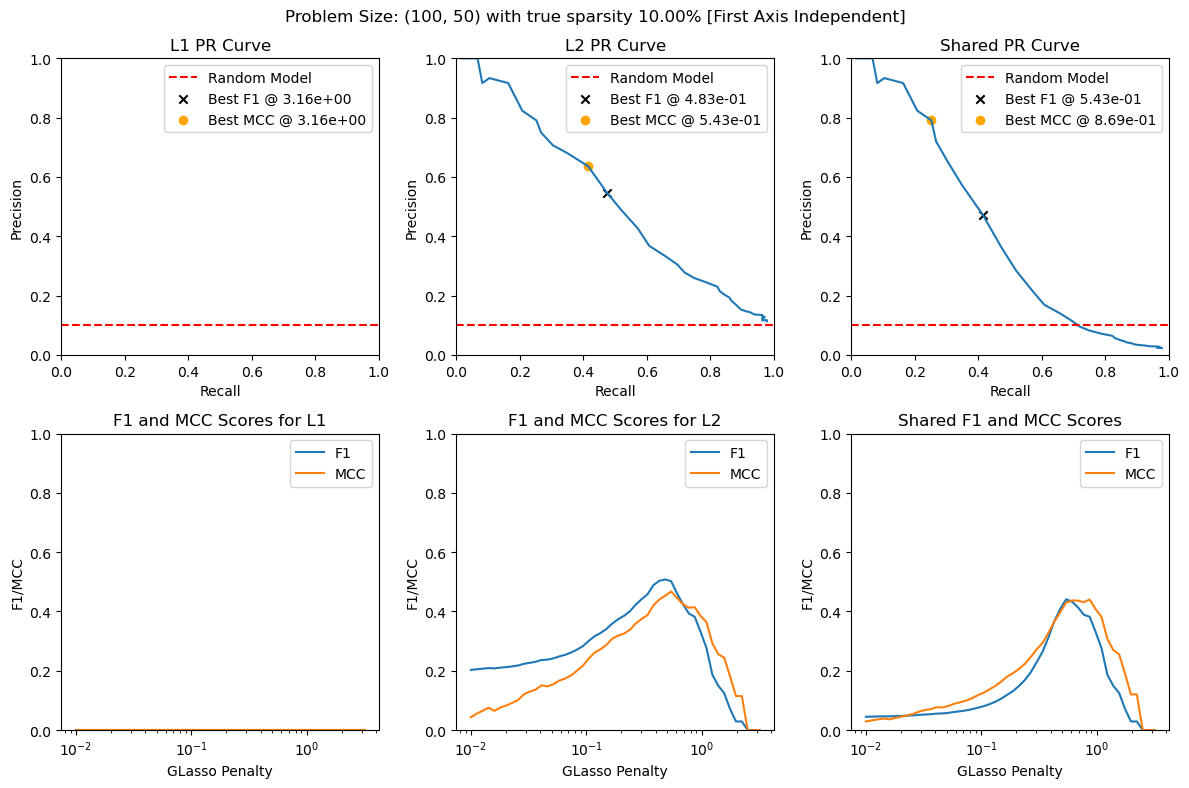

In [557]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (100, 50)
sparsity = 0.1

L_stars, L_patterns = generate_Ls(n, sparsity)
L_stars[0] = np.eye(L_stars[0].shape[0])
L_patterns[0] = np.zeros_like(L_stars[0]) != 0
X = generate_sylvester_data(L_stars, normalize=True)
print("Data generated")

L_inits = []
for i in range(len(n)):
    L_init = np.tril(np.random.randn(n[i], n[i]))
    np.fill_diagonal(L_init, np.abs(np.diag(L_init)) + 1.0)
    L_inits.append(L_init)
#glassoregs = np.logspace(1, -2, 50) # (50, 50)
#glassoregs = np.logspace(1, -1, 50) # (75, 75)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 100)
glassoregs = np.logspace(0.5, -2, 50) # (100, 50)
Lss, diags = warm_start(X, L_inits, glassoregs=glassoregs)
print("Model fit")


L_estim_patterns = []
for Ls in Lss:
    to_add = []
    for L in Ls:
        pattern = np.abs(L) > 1e-16
        np.fill_diagonal(pattern, 0)
        to_add.append(pattern)
    L_estim_patterns.append(to_add)

TPs = np.array([
    [
        np.tril(L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FPs = np.array([
    [
        np.tril(~L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
TNs = np.array([
    [
        np.tril(~L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FNs = np.array([
    [
        np.tril(L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T

shared_TPs = TPs.sum(axis=0)
shared_FPs = FPs.sum(axis=0)
shared_TNs = TNs.sum(axis=0)
shared_FNs = FNs.sum(axis=0)

precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(n))]
shared_precs = shared_TPs / (shared_TPs + shared_FPs)
recs = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(n))]
shared_recs = shared_TPs / (shared_TPs + shared_FNs)

f1s = [2*precs[i]*recs[i]/(precs[i]+recs[i]) for i in range(len(n))]
mccs = [
    (TPs[i]*TNs[i] - FPs[i]*FNs[i])
    / np.sqrt((TPs[i]+FPs[i])*(TPs[i]+FNs[i])*(TNs[i]+FPs[i])*(TNs[i]+FNs[i]))
    for i in range(len(n))
]
for i in range(len(f1s)):
    f1s[i][np.isnan(f1s[i])] = 0
    mccs[i][np.isnan(mccs[i])] = 0

shared_f1s =  2 * (shared_precs * shared_recs)/(shared_precs + shared_recs)
shared_f1s[np.isnan(shared_f1s)] = 0
shared_mccs = (
    (shared_TPs * shared_TNs - shared_FPs * shared_FNs)
    / np.sqrt(
        (shared_TPs + shared_FPs)
        * (shared_TPs + shared_FNs)
        * (shared_TNs + shared_FPs)
        * (shared_TNs + shared_FNs)
    )
)
shared_mccs[np.isnan(shared_mccs)] = 0

Ls_maxF1 = [np.argmax(f1) for f1 in f1s]
sh_maxF1 = np.argmax(shared_f1s)
Ls_maxMCC = [np.argmax(mcc) for mcc in mccs]
sh_maxMCC = np.argmax(shared_mccs)

fig, (pr_axes, f1mcc_axes) = plt.subplots(ncols=len(n)+1, nrows=2, figsize=(12, 8))

for i, ax in enumerate(pr_axes):
    if i < len(pr_axes) - 1:
        precision = precs[i]
        recall = recs[i]
        best_greg_f1_idx = Ls_maxF1[i]
        best_greg_mcc_idx = Ls_maxMCC[i]
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"L{i+1} PR Curve")
    else:
        precision = shared_precs
        recall = shared_recs
        best_greg_f1_idx = sh_maxF1
        best_greg_mcc_idx = sh_maxMCC
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"Shared PR Curve")
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axhline(sparsity, label="Random Model", linestyle='--', color='red')

    best_prec_f1 = precision[best_greg_f1_idx]
    best_rec_f1 = recall[best_greg_f1_idx]
    ax.scatter(best_rec_f1, best_prec_f1, marker='x', color='black', label=f"Best F1 @ {best_greg_f1:.2e}")

    best_prec_mcc = precision[best_greg_mcc_idx]
    best_rec_mcc = recall[best_greg_mcc_idx]
    ax.scatter(best_rec_mcc, best_prec_mcc, marker='o', color='orange', label=f"Best MCC @ {best_greg_mcc:.2e}")

    ax.legend()

for i, ax in enumerate(f1mcc_axes):
    if i < len(pr_axes) - 1:
        cur_f1 = f1s[i]
        cur_mcc = mccs[i]
        ax.set_title(f"F1 and MCC Scores for L{i+1}")
    else:
        cur_f1 = shared_f1s
        cur_mcc = shared_mccs
        ax.set_title("Shared F1 and MCC Scores")
    ax.plot(glassoregs, cur_f1, label="F1")
    ax.plot(glassoregs, cur_mcc, label="MCC")
    ax.set_xlabel("GLasso Penalty")
    ax.set_ylabel("F1/MCC")
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    #tax = ax.twinx()
    #mcc, = tax.plot(glassoregs, cur_mcc, label="MCC", color="orange")
    #tax.set_ylabel("MCC")
    ax.legend()#[f1, mcc], [f1.get_label(), mcc.get_label()])

fig.suptitle(f"Problem Size: {n} with true sparsity {sparsity:.2%} [First Axis Independent]")
fig.tight_layout()

In [559]:
np.random.seed(1)

def generate_Ls(dims: tuple[int, ...], sparsity: float) -> tuple[list[FactorMatrix], list[FactorMatrix]]:
    Ls = []
    L_patterns = []

    for d in dims:
        L_star = np.tril(np.random.randn(d, d))

        # generate bernoulli sparsity pattern
        L_star[np.random.rand(*L_star.shape) > sparsity] = 0
        L_pattern = (np.abs(np.tril(L_star, k=-1)) > 1e-16)
        np.fill_diagonal(L_star, 2)
        np.fill_diagonal(L_pattern, 0)

        Ls.append(L_star)
        L_patterns.append(L_pattern)

    return Ls, L_patterns

def generate_sylvester_data(
        Ls: list[FactorMatrix],
        normalize: bool=False,
        source_distribution: Callable[[tuple[int,...]], np.ndarray] = np.random.normal
    ) -> InputData:
    """
    Generates data that follows the tensor-variate sylvester equation
    """
    n = [L.shape[0] for L in Ls]
    dim = len(n)

    if dim == 2:
        # Matrix variate equation sub-case; already a SciPy routine to do this!
        # Note that the routine has some preprocessing steps to triangularize our
        # matrices, which is not needed here, so to squeeze out extra efficiency
        # one could drop down to the lapack dtrsyl routine.
        X = linalg.solve_sylvester(Ls[0], Ls[1], source_distribution(size=n))
    else:
        # There is literature on solving this, but in general the problem is
        # more difficult and there do not exist SciPy routines.
        # So, we'll take the 'lazy way' and reduce it to the dim=2 case.
        # Note that this has egregious space requirements.  In general,
        # if all K axes have size d, then this algorithm transforms the
        # data into two d^(K // 2) x d^(K // 2) matrices.
        # That's a bit expensive...
        #
        # Essentially, we can handle small tensors up to dim=4, after which
        # all bets are off!
        left_Ls = Ls[:(dim // 2)]
        right_Ls = Ls[(dim // 2):]

        left_L = left_Ls[0]
        for L in left_Ls[1:]:
            left_L = np.kron(left_L, np.eye(L.shape[0])) + np.kron(np.eye(left_L.shape[0]), L)
        right_L = right_Ls[0]
        for L in right_Ls[1:]:
            right_L = np.kron(right_L, np.eye(L.shape[0])) + np.kron(np.eye(right_L.shape[0]), L)
        
        X = linalg.solve_sylvester(
            left_L,
            right_L,
            source_distribution(size=(left_L.shape[0], right_L.shape[0]))
        ).reshape(n)

    if normalize:
        X /= np.sqrt((X**2).sum())
    return X

n = (20, 21, 22, 23)
Ls, _ = generate_Ls((20, 21, 22, 23), 0.1)
generate_sylvester_data(Ls, normalize=True, source_distribution=np.random.gumbel).shape

(20, 21, 22, 23)

Data generated
L1 Param: 1.5848931924611136


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/3950260077.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 1.4979944491588246
L1 Param: 1.4158603118397253
L1 Param: 1.3382295400150317
L1 Param: 1.2648552168552962
L1 Param: 1.1955039638327576
L1 Param: 1.1299551984243779
L1 Param: 1.0680004325145758
L1 Param: 1.0094426092661206
L1 Param: 0.954095476349994
L1 Param: 0.9017829935406847
L1 Param: 0.8523387727926771
L1 Param: 0.8056055490172106
L1 Param: 0.761434679876031
L1 Param: 0.719685673001152
L1 Param: 0.6802257391368727
L1 Param: 0.6429293697827496
L1 Param: 0.6076779379941533
L1 Param: 0.574359321070689
L1 Param: 0.5428675439323861
L1 Param: 0.5131024420493568
L1 Param: 0.4849693428528199
L1 Param: 0.45837876461416605
L1 Param: 0.43324613183430505
L1 Param: 0.4094915062380426
L1 Param: 0.3870393325178753
L1 Param: 0.36581819801850096
L1 Param: 0.345760605597682
L1 Param: 0.32680275894101257
L1 Param: 0.3088843596477482
L1 Param: 0.29194841544229644
L1 Param: 0.2759410589013586
L1 Param: 0.2608113761201518
L1 Param: 0.24651124477275946
L1 Param: 0.2329951810515372
L1 Param: 0.2

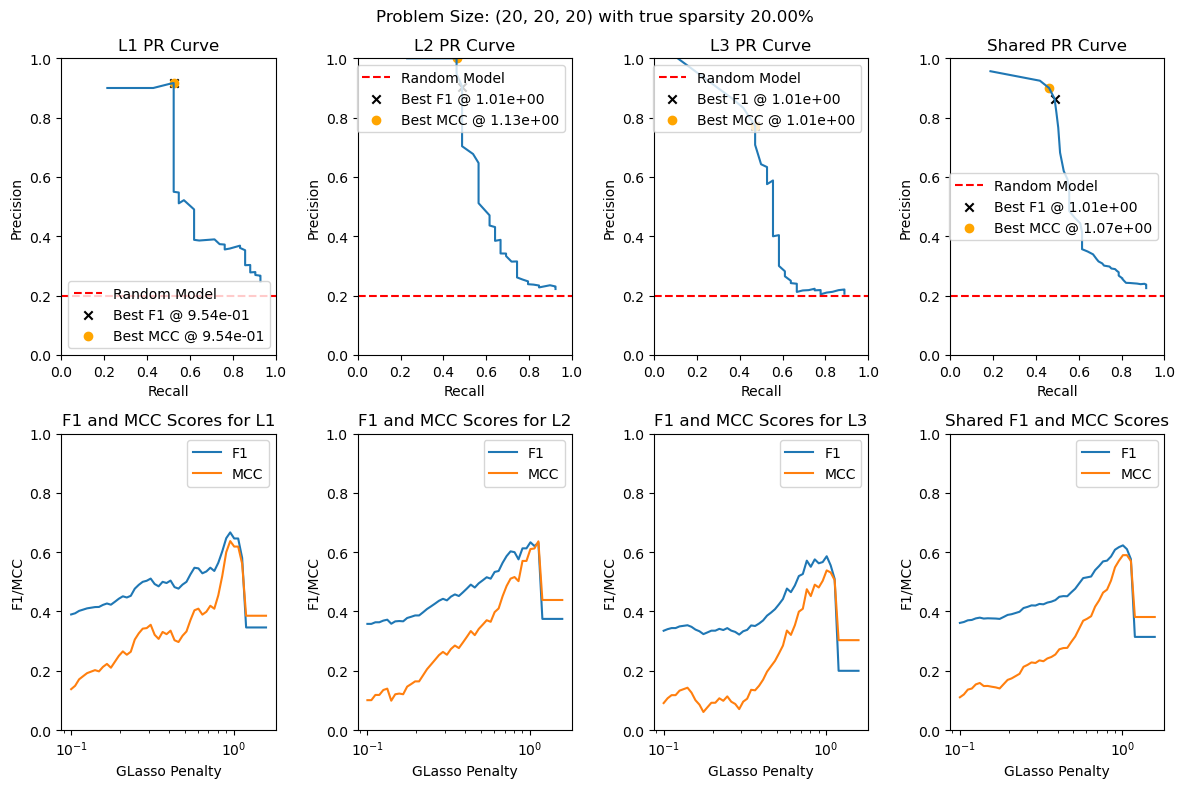

In [566]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (20, 20, 20)
sparsity = 0.2

L_stars, L_patterns = generate_Ls(n, sparsity)
X = generate_sylvester_data(L_stars, normalize=True)
print("Data generated")

L_inits = []
for i in range(len(n)):
    L_init = np.tril(np.random.randn(n[i], n[i]))
    np.fill_diagonal(L_init, np.abs(np.diag(L_init)) + 1.0)
    L_inits.append(L_init)
#glassoregs = np.logspace(1, -2, 50) # (50, 50)
#glassoregs = np.logspace(1, -1, 50) # (75, 75)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 100)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 50)
glassoregs = np.logspace(0.2, -1, 50) # (20, 20, 20)
Lss, diags = warm_start(X, L_inits, glassoregs=glassoregs)
print("Model fit")


L_estim_patterns = []
for Ls in Lss:
    to_add = []
    for L in Ls:
        pattern = np.abs(L) > 1e-16
        np.fill_diagonal(pattern, 0)
        to_add.append(pattern)
    L_estim_patterns.append(to_add)

TPs = np.array([
    [
        np.tril(L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FPs = np.array([
    [
        np.tril(~L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
TNs = np.array([
    [
        np.tril(~L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FNs = np.array([
    [
        np.tril(L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T

shared_TPs = TPs.sum(axis=0)
shared_FPs = FPs.sum(axis=0)
shared_TNs = TNs.sum(axis=0)
shared_FNs = FNs.sum(axis=0)

precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(n))]
shared_precs = shared_TPs / (shared_TPs + shared_FPs)
recs = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(n))]
shared_recs = shared_TPs / (shared_TPs + shared_FNs)

f1s = [2*precs[i]*recs[i]/(precs[i]+recs[i]) for i in range(len(n))]
mccs = [
    (TPs[i]*TNs[i] - FPs[i]*FNs[i])
    / np.sqrt((TPs[i]+FPs[i])*(TPs[i]+FNs[i])*(TNs[i]+FPs[i])*(TNs[i]+FNs[i]))
    for i in range(len(n))
]
for i in range(len(f1s)):
    f1s[i][np.isnan(f1s[i])] = 0
    mccs[i][np.isnan(mccs[i])] = 0

shared_f1s =  2 * (shared_precs * shared_recs)/(shared_precs + shared_recs)
shared_f1s[np.isnan(shared_f1s)] = 0
shared_mccs = (
    (shared_TPs * shared_TNs - shared_FPs * shared_FNs)
    / np.sqrt(
        (shared_TPs + shared_FPs)
        * (shared_TPs + shared_FNs)
        * (shared_TNs + shared_FPs)
        * (shared_TNs + shared_FNs)
    )
)
shared_mccs[np.isnan(shared_mccs)] = 0

Ls_maxF1 = [np.argmax(f1) for f1 in f1s]
sh_maxF1 = np.argmax(shared_f1s)
Ls_maxMCC = [np.argmax(mcc) for mcc in mccs]
sh_maxMCC = np.argmax(shared_mccs)

fig, (pr_axes, f1mcc_axes) = plt.subplots(ncols=len(n)+1, nrows=2, figsize=(12, 8))

for i, ax in enumerate(pr_axes):
    if i < len(pr_axes) - 1:
        precision = precs[i]
        recall = recs[i]
        best_greg_f1_idx = Ls_maxF1[i]
        best_greg_mcc_idx = Ls_maxMCC[i]
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"L{i+1} PR Curve")
    else:
        precision = shared_precs
        recall = shared_recs
        best_greg_f1_idx = sh_maxF1
        best_greg_mcc_idx = sh_maxMCC
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"Shared PR Curve")
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axhline(sparsity, label="Random Model", linestyle='--', color='red')

    best_prec_f1 = precision[best_greg_f1_idx]
    best_rec_f1 = recall[best_greg_f1_idx]
    ax.scatter(best_rec_f1, best_prec_f1, marker='x', color='black', label=f"Best F1 @ {best_greg_f1:.2e}")

    best_prec_mcc = precision[best_greg_mcc_idx]
    best_rec_mcc = recall[best_greg_mcc_idx]
    ax.scatter(best_rec_mcc, best_prec_mcc, marker='o', color='orange', label=f"Best MCC @ {best_greg_mcc:.2e}")

    ax.legend()

for i, ax in enumerate(f1mcc_axes):
    if i < len(pr_axes) - 1:
        cur_f1 = f1s[i]
        cur_mcc = mccs[i]
        ax.set_title(f"F1 and MCC Scores for L{i+1}")
    else:
        cur_f1 = shared_f1s
        cur_mcc = shared_mccs
        ax.set_title("Shared F1 and MCC Scores")
    ax.plot(glassoregs, cur_f1, label="F1")
    ax.plot(glassoregs, cur_mcc, label="MCC")
    ax.set_xlabel("GLasso Penalty")
    ax.set_ylabel("F1/MCC")
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    #tax = ax.twinx()
    #mcc, = tax.plot(glassoregs, cur_mcc, label="MCC", color="orange")
    #tax.set_ylabel("MCC")
    ax.legend()#[f1, mcc], [f1.get_label(), mcc.get_label()])

fig.suptitle(f"Problem Size: {n} with true sparsity {sparsity:.2%}")
fig.tight_layout()

Data generated
L1 Param: 3.1622776601683795


/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_80934/3950260077.py:26: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 2.947051702551811
L1 Param: 2.7464741148160523
L1 Param: 2.5595479226995357
L1 Param: 2.3853440064314197
L1 Param: 2.2229964825261948
L1 Param: 2.0716983998953076
L1 Param: 1.93069772888325
L1 Param: 1.7992936232915528
L1 Param: 1.6768329368110082
L1 Param: 1.5627069765469952
L1 Param: 1.4563484775012439
L1 Param: 1.3572287829716538
L1 Param: 1.264855216855296
L1 Param: 1.1787686347935873
L1 Param: 1.0985411419875581
L1 Param: 1.023773966339585
L1 Param: 0.9540954763499939
L1 Param: 0.8891593339164642
L1 Param: 0.8286427728546845
L1 Param: 0.7722449945836258
L1 Param: 0.7196856730011522
L1 Param: 0.6707035611184308
L1 Param: 0.6250551925273973
L1 Param: 0.5825136712468927
L1 Param: 0.5428675439323861
L1 Param: 0.5059197488435825
L1 Param: 0.47148663634573934
L1 Param: 0.43939705607607915
L1 Param: 0.40949150623804254
L1 Param: 0.3816213407949356
L1 Param: 0.3556480306223129
L1 Param: 0.33144247494664264
L1 Param: 0.3088843596477482
L1 Param: 0.2878615592354568
L1 Param: 0.268

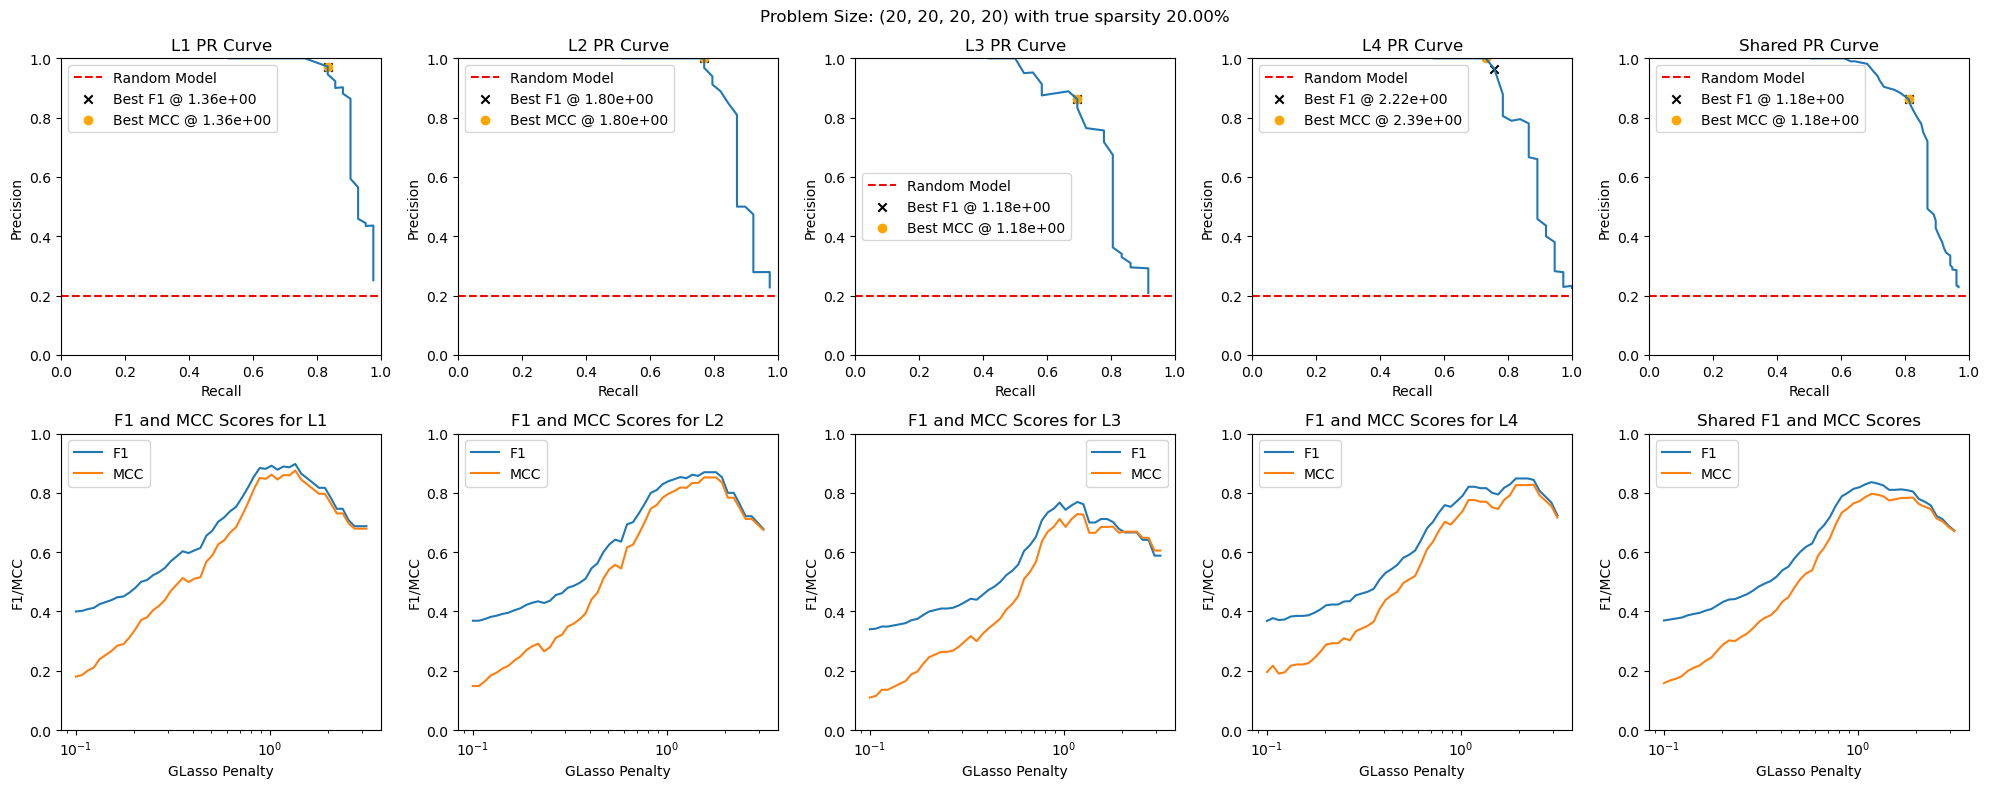

In [574]:
def warm_start(
    X: InputData,
    L_init: list[FactorMatrix],
    *,
    glassoregs: list[float],
    frobreg: Optional[float] = None,
    mu: Momentum = 0.2,
    init_alpha: StepSize = 1,
    tau: float = 0.5,
    beta: float = 0.0001,
    max_iter: int = 50000,
    tol: float = 1e-20,
    verbose: bool = True
) -> tuple[list[list[FactorMatrix]], dict[float, Diagnostics]]:
    if frobreg is None:
        frobreg = 1/np.prod(n)**(1/len(n))
    Ls = L_init
    diagnostics = dict({glassoreg: None for glassoreg in glassoregs})
    outputs = []
    for glassoreg in glassoregs:
        if verbose:
            print(f"L1 Param: {glassoreg}")
        objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, diags = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=Ls,
            mu=mu,
            init_alpha=init_alpha,
            tau=tau,
            beta=beta,
            max_iter=max_iter,
            tol=tol
        )
        diagnostics[glassoreg] = diags
        outputs.append(Ls)
    return outputs, diagnostics

np.random.seed(0)
n = (20, 20, 20, 20)
sparsity = 0.2

L_stars, L_patterns = generate_Ls(n, sparsity)
X = generate_sylvester_data(L_stars, normalize=True)
print("Data generated")

L_inits = []
for i in range(len(n)):
    L_init = np.tril(np.random.randn(n[i], n[i]))
    np.fill_diagonal(L_init, np.abs(np.diag(L_init)) + 1.0)
    L_inits.append(L_init)
#glassoregs = np.logspace(1, -2, 50) # (50, 50)
#glassoregs = np.logspace(1, -1, 50) # (75, 75)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 100)
#glassoregs = np.logspace(0.5, -2, 50) # (100, 50)
#glassoregs = np.logspace(0.2, -1, 50) # (20, 20, 20)
glassoregs = np.logspace(0.5, -1, 50) # (20, 20, 20, 20)
Lss, diags = warm_start(X, L_inits, glassoregs=glassoregs)
print("Model fit")


L_estim_patterns = []
for Ls in Lss:
    to_add = []
    for L in Ls:
        pattern = np.abs(L) > 1e-16
        np.fill_diagonal(pattern, 0)
        to_add.append(pattern)
    L_estim_patterns.append(to_add)

TPs = np.array([
    [
        np.tril(L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FPs = np.array([
    [
        np.tril(~L_pattern & L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
TNs = np.array([
    [
        np.tril(~L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T
FNs = np.array([
    [
        np.tril(L_pattern & ~L_estim_pattern, k=-1).sum()
        for L_pattern, L_estim_pattern in zip(L_patterns, version)
    ]
    for version in L_estim_patterns
]).T

shared_TPs = TPs.sum(axis=0)
shared_FPs = FPs.sum(axis=0)
shared_TNs = TNs.sum(axis=0)
shared_FNs = FNs.sum(axis=0)

precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(n))]
shared_precs = shared_TPs / (shared_TPs + shared_FPs)
recs = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(n))]
shared_recs = shared_TPs / (shared_TPs + shared_FNs)

f1s = [2*precs[i]*recs[i]/(precs[i]+recs[i]) for i in range(len(n))]
mccs = [
    (TPs[i]*TNs[i] - FPs[i]*FNs[i])
    / np.sqrt((TPs[i]+FPs[i])*(TPs[i]+FNs[i])*(TNs[i]+FPs[i])*(TNs[i]+FNs[i]))
    for i in range(len(n))
]
for i in range(len(f1s)):
    f1s[i][np.isnan(f1s[i])] = 0
    mccs[i][np.isnan(mccs[i])] = 0

shared_f1s =  2 * (shared_precs * shared_recs)/(shared_precs + shared_recs)
shared_f1s[np.isnan(shared_f1s)] = 0
shared_mccs = (
    (shared_TPs * shared_TNs - shared_FPs * shared_FNs)
    / np.sqrt(
        (shared_TPs + shared_FPs)
        * (shared_TPs + shared_FNs)
        * (shared_TNs + shared_FPs)
        * (shared_TNs + shared_FNs)
    )
)
shared_mccs[np.isnan(shared_mccs)] = 0

Ls_maxF1 = [np.argmax(f1) for f1 in f1s]
sh_maxF1 = np.argmax(shared_f1s)
Ls_maxMCC = [np.argmax(mcc) for mcc in mccs]
sh_maxMCC = np.argmax(shared_mccs)

fig, (pr_axes, f1mcc_axes) = plt.subplots(ncols=len(n)+1, nrows=2, figsize=(4+4*X.ndim, 8))

for i, ax in enumerate(pr_axes):
    if i < len(pr_axes) - 1:
        precision = precs[i]
        recall = recs[i]
        best_greg_f1_idx = Ls_maxF1[i]
        best_greg_mcc_idx = Ls_maxMCC[i]
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"L{i+1} PR Curve")
    else:
        precision = shared_precs
        recall = shared_recs
        best_greg_f1_idx = sh_maxF1
        best_greg_mcc_idx = sh_maxMCC
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"Shared PR Curve")
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axhline(sparsity, label="Random Model", linestyle='--', color='red')

    best_prec_f1 = precision[best_greg_f1_idx]
    best_rec_f1 = recall[best_greg_f1_idx]
    ax.scatter(best_rec_f1, best_prec_f1, marker='x', color='black', label=f"Best F1 @ {best_greg_f1:.2e}")

    best_prec_mcc = precision[best_greg_mcc_idx]
    best_rec_mcc = recall[best_greg_mcc_idx]
    ax.scatter(best_rec_mcc, best_prec_mcc, marker='o', color='orange', label=f"Best MCC @ {best_greg_mcc:.2e}")

    ax.legend()

for i, ax in enumerate(f1mcc_axes):
    if i < len(pr_axes) - 1:
        cur_f1 = f1s[i]
        cur_mcc = mccs[i]
        ax.set_title(f"F1 and MCC Scores for L{i+1}")
    else:
        cur_f1 = shared_f1s
        cur_mcc = shared_mccs
        ax.set_title("Shared F1 and MCC Scores")
    ax.plot(glassoregs, cur_f1, label="F1")
    ax.plot(glassoregs, cur_mcc, label="MCC")
    ax.set_xlabel("GLasso Penalty")
    ax.set_ylabel("F1/MCC")
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    #tax = ax.twinx()
    #mcc, = tax.plot(glassoregs, cur_mcc, label="MCC", color="orange")
    #tax.set_ylabel("MCC")
    ax.legend()#[f1, mcc], [f1.get_label(), mcc.get_label()])

fig.suptitle(f"Problem Size: {n} with true sparsity {sparsity:.2%}")
fig.tight_layout()

[array([0.96969697, 0.96969697, 0.97058824, 0.94594595, 0.94594595,
       0.92307692, 0.9       , 0.90243902, 0.90243902, 0.88095238,
       0.88372093, 0.82608696, 0.76      , 0.74509804, 0.69090909,
       0.65517241, 0.63333333, 0.61290323, 0.58461538, 0.56521739,
       0.52702703, 0.51315789, 0.5       , 0.45977011, 0.44444444,
       0.43478261, 0.44086022, 0.43157895, 0.41414141, 0.40196078,
       0.38317757, 0.36936937, 0.35964912, 0.35344828, 0.34166667,
       0.33606557, 0.32539683, 0.3129771 , 0.3037037 , 0.29285714,
       0.29078014, 0.28472222, 0.27891156, 0.27516779, 0.27152318,
       0.26282051, 0.2611465 , 0.25465839, 0.25308642, 0.25153374]), array([0.90909091, 0.90909091, 0.9375    , 0.93939394, 0.91176471,
       0.88571429, 0.86486486, 0.825     , 0.79069767, 0.79069767,
       0.77272727, 0.75555556, 0.72340426, 0.66666667, 0.62962963,
       0.59649123, 0.5862069 , 0.57627119, 0.5       , 0.5       ,
       0.47368421, 0.4556962 , 0.43373494, 0.40449438, 0.38

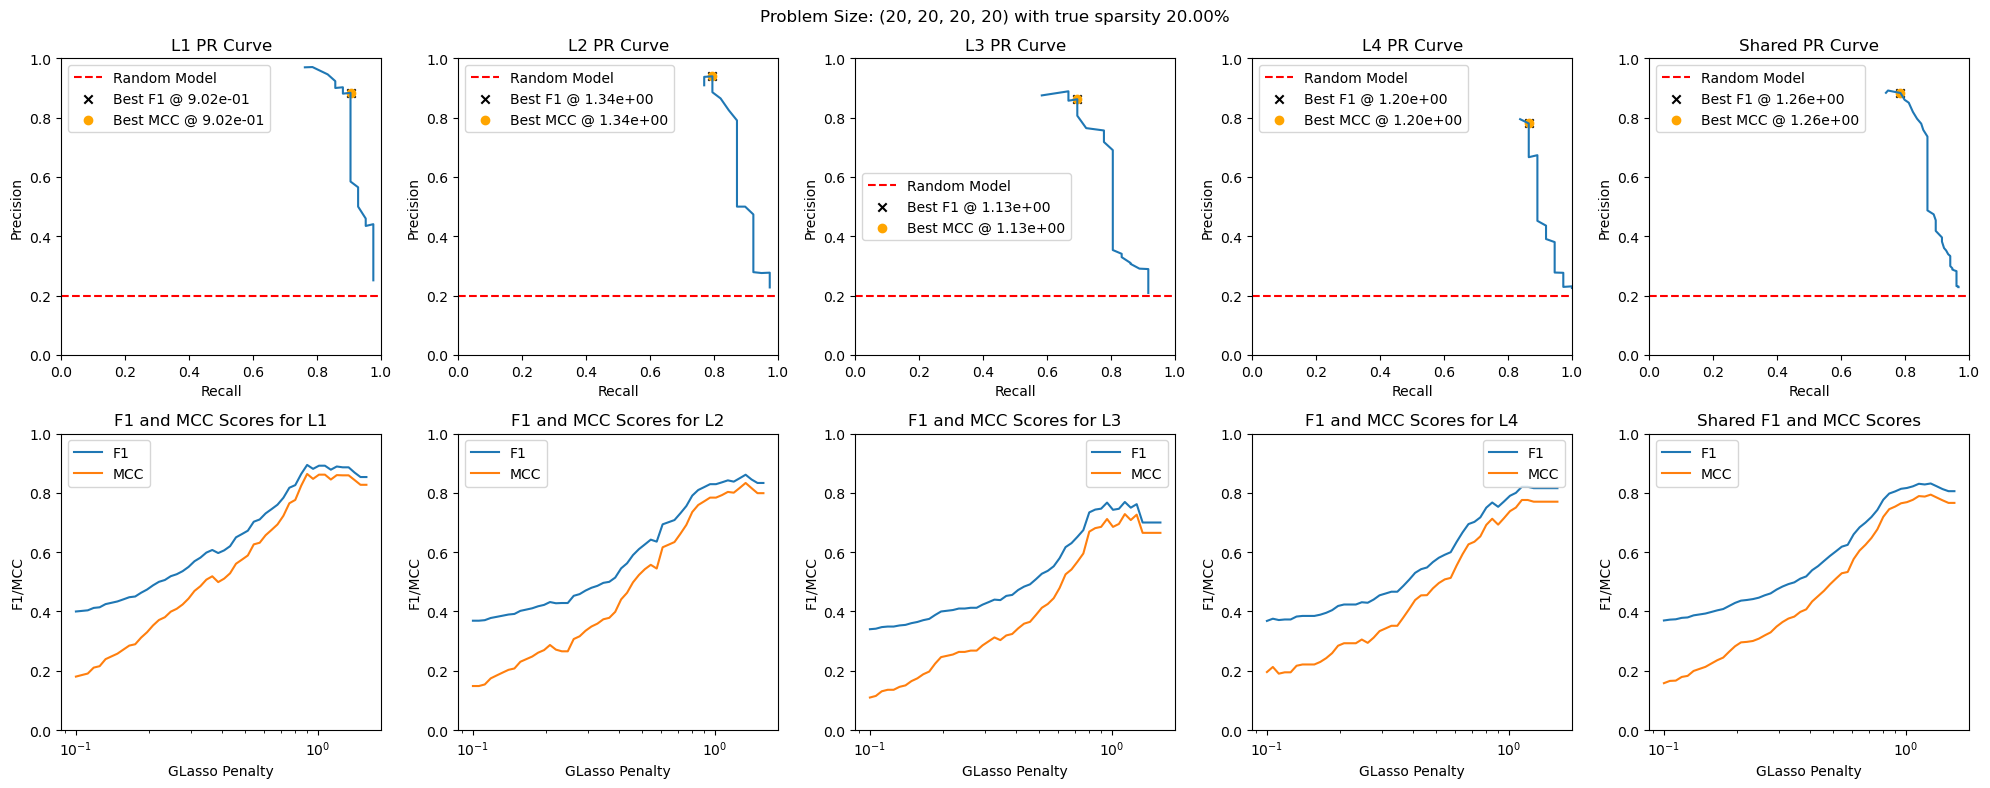

In [ ]:
precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(n))]
shared_precs = shared_TPs / (shared_TPs + shared_FPs)
recs = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(n))]
shared_recs = shared_TPs / (shared_TPs + shared_FNs)

# Handle denominator being 0
for i in range(len(n)):
    precs[i][TPs[i]+FPs[i]==0] = 1
    recs[i][TPs[i]+FNs[i]==0] = 1
shared_precs[shared_TPs + shared_FPs==0] = 1
shared_recs[shared_TPs + shared_FNs==0] = 1

f1s = [2*precs[i]*recs[i]/(precs[i]+recs[i]) for i in range(len(n))]
mccs = [
    (TPs[i]*TNs[i] - FPs[i]*FNs[i])
    / np.sqrt((TPs[i]+FPs[i])*(TPs[i]+FNs[i])*(TNs[i]+FPs[i])*(TNs[i]+FNs[i]))
    for i in range(len(n))
]
for i in range(len(f1s)):
    f1s[i][np.isnan(f1s[i])] = 0
    mccs[i][np.isnan(mccs[i])] = 0

shared_f1s =  2 * (shared_precs * shared_recs)/(shared_precs + shared_recs)
shared_f1s[np.isnan(shared_f1s)] = 0
shared_mccs = (
    (shared_TPs * shared_TNs - shared_FPs * shared_FNs)
    / np.sqrt(
        (shared_TPs + shared_FPs)
        * (shared_TPs + shared_FNs)
        * (shared_TNs + shared_FPs)
        * (shared_TNs + shared_FNs)
    )
)
shared_mccs[np.isnan(shared_mccs)] = 0

Ls_maxF1 = [np.argmax(f1) for f1 in f1s]
sh_maxF1 = np.argmax(shared_f1s)
Ls_maxMCC = [np.argmax(mcc) for mcc in mccs]
sh_maxMCC = np.argmax(shared_mccs)

fig, (pr_axes, f1mcc_axes) = plt.subplots(ncols=len(n)+1, nrows=2, figsize=(4+4*X.ndim, 8))

for i, ax in enumerate(pr_axes):
    if i < len(pr_axes) - 1:
        precision = precs[i]
        recall = recs[i]
        best_greg_f1_idx = Ls_maxF1[i]
        best_greg_mcc_idx = Ls_maxMCC[i]
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"L{i+1} PR Curve")
    else:
        precision = shared_precs
        recall = shared_recs
        best_greg_f1_idx = sh_maxF1
        best_greg_mcc_idx = sh_maxMCC
        best_greg_f1 = glassoregs[best_greg_f1_idx]
        best_greg_mcc = glassoregs[best_greg_mcc_idx]
        ax.set_title(f"Shared PR Curve")
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axhline(sparsity, label="Random Model", linestyle='--', color='red')

    best_prec_f1 = precision[best_greg_f1_idx]
    best_rec_f1 = recall[best_greg_f1_idx]
    ax.scatter(best_rec_f1, best_prec_f1, marker='x', color='black', label=f"Best F1 @ {best_greg_f1:.2e}")

    best_prec_mcc = precision[best_greg_mcc_idx]
    best_rec_mcc = recall[best_greg_mcc_idx]
    ax.scatter(best_rec_mcc, best_prec_mcc, marker='o', color='orange', label=f"Best MCC @ {best_greg_mcc:.2e}")

    ax.legend()

for i, ax in enumerate(f1mcc_axes):
    if i < len(pr_axes) - 1:
        cur_f1 = f1s[i]
        cur_mcc = mccs[i]
        ax.set_title(f"F1 and MCC Scores for L{i+1}")
    else:
        cur_f1 = shared_f1s
        cur_mcc = shared_mccs
        ax.set_title("Shared F1 and MCC Scores")
    ax.plot(glassoregs, cur_f1, label="F1")
    ax.plot(glassoregs, cur_mcc, label="MCC")
    ax.set_xlabel("GLasso Penalty")
    ax.set_ylabel("F1/MCC")
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    #tax = ax.twinx()
    #mcc, = tax.plot(glassoregs, cur_mcc, label="MCC", color="orange")
    #tax.set_ylabel("MCC")
    ax.legend()#[f1, mcc], [f1.get_label(), mcc.get_label()])

fig.suptitle(f"Problem Size: {n} with true sparsity {sparsity:.2%}")
fig.tight_layout()